# Two-qubit States Reconstruction

In [2]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import amplitude_damping_error
from qiskit.providers.aer.noise import kraus_error

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.python.framework.ops import convert_to_tensor

TensorFlow version: 2.11.0


In [3]:
#Ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

## Data Generation

In [4]:
# Generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [5]:
#Function which generates the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [6]:
#Function which computes the components of the Bloch vector, given the density matrix 

#Here we define the identity matrix and the Pauli matrices for dimension 2 (one qubit)
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return pnt

In [7]:
#Function to represent the data on the Bloch sphere

def Bloch_sphere(data):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection='3d')
    qk.visualization.plot_bloch_vector([0, 0, 0], title='Bloch Sphere',ax=ax)
    for (x, y, z) in data:
        ax.scatter3D(y, -x, z, c='b') #here x and y axis are inverted in order to match qiskit and matplotlib axis
        #ax.plot(y, -x, z, marker='.', c='b', alpha=0.7)

In [8]:
#Choice of simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [9]:
def generate_Haar_data(num_qubits, samples=1000):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #it's used to optimize the circuit
        qc.save_statevector() #it's the instruction to save the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

## Useful Functions

In [10]:
pauli_basis1q = np.array([I, X, Y, Z])
pauli_basis2q = np.array([np.kron(a,b) for a in pauli_basis1q for b in pauli_basis1q])
pauli_basis2q_modified = pauli_basis2q[1:]

#function which returns bloch components from density matrix
def bloch_coeffs(rho):
    c = []
    for p in pauli_basis2q_modified:
        c.append(np.trace(rho @ p))
    return np.array(c)

In [11]:
I_4 = tf.constant([[1.0, 0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0]],shape=(4,4), dtype = tf.complex64)
def fid_twoq(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, a)
   el_b = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, b)
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   return fidelity 

In [19]:
I_tf = tf.constant([1.0, 0.0,0.0,1.0],shape=(2,2), dtype = tf.complex64)
X_tf = tf.constant([0.0, 1.0, 1.0, 0.0],shape=(2,2), dtype = tf.complex64)
Y_tf = tf.constant([0.0+0j, 0.0-1j ,0.0+1j,0.0+0j],shape=(2,2), dtype = tf.complex64)
Z_tf = tf.constant([1.0, 0.0,0.0,-1.0],shape=(2,2), dtype = tf.complex64)

In [20]:
A = tf.stack([X_tf,Y_tf,Z_tf])

In [52]:
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,a) 
   el_b = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,b) 
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   infidelity = 1 - fidelity
   return infidelity 

## Noise Model

In [12]:
#num_qubits = 1

#PROBABILITIES FOR BIT, PHASE, BIT-PHASE FLIP OR DEPOLARIZING CHANNELS
p_error = 0.2
    
#PROBABILITIES FOR GENERAL PAULI CHANNEL
p_0=0.7
p_1=0.2
p_2=0.05
p_3=0.05
    
#PARAMETERS FOR KRAUS CHANNEL
alpha = np.pi / 3
beta = np.pi / 6
    
A_0 = np.array([[np.cos (alpha), 0], [0, np.cos (beta)]])
A_1 = np.array([[0, np.sin (beta)], [np.sin (alpha), 0]])
Kraus_operators = [A_0, A_1]
    
bit_flip_error = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip_error = pauli_error([('Z', p_error), ('I', 1 - p_error)])
bit_phase_flip_error = pauli_error([('Y', p_error), ('I', 1 - p_error)])
#dep_error = depolarizing_error(p_error, num_qubits)
general_pauli_error = pauli_error([('X', p_1), ('Y', p_2), ('Z', p_3), ('I', p_0)])
AD_error = amplitude_damping_error (0.3, 0.5) 
k_error = kraus_error(Kraus_operators)

In [13]:
#applies NOISE whenever an identity gate appears in the circuit (compatibly with the channels parameters)
def qsk_add_error(error_type):
    if error_type == 'bit':
        noise_model.add_all_qubit_quantum_error(bit_flip_error, ["id"])
    if error_type == 'phase':
        noise_model.add_all_qubit_quantum_error(phase_flip_error, ["id"])
    if error_type == 'bit-phase':
        noise_model.add_all_qubit_quantum_error(bit_phase_flip_error, ["id"])
    if error_type == 'depolarizing':
        noise_model.add_all_qubit_quantum_error(dep_error, ["id"])
    if error_type == 'Gpauli':
        noise_model.add_all_qubit_quantum_error(general_pauli_error, ["id"])
    if error_type == 'AD':
        noise_model.add_all_qubit_quantum_error(AD_error, ["id"])
    if error_type == 'Kraus':
        noise_model.add_all_qubit_quantum_error(k_error, ["id"])

##  <font color='green'>Training the Algorithm (MSE)</font>

### <font color='green'>Different Channels on both Qubits</font>

In [13]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [14]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()
    #print(circ)
    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(bit_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [17]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [42]:
x_train_list = vectors_with_noise[:300]
y_train_list = vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[400:800]
y_val_list = vectors_noise_free[400:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [43]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [44]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [45]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=500)

Epoch 1/500
6/6 [==============================] - 2s 68ms/step - loss: 0.2011 - val_loss: 0.1896
Epoch 2/500
6/6 [==============================] - 0s 23ms/step - loss: 0.1852 - val_loss: 0.1768
Epoch 3/500
6/6 [==============================] - 0s 26ms/step - loss: 0.1720 - val_loss: 0.1649
Epoch 4/500
6/6 [==============================] - 0s 24ms/step - loss: 0.1594 - val_loss: 0.1532
Epoch 5/500
6/6 [==============================] - 0s 21ms/step - loss: 0.1469 - val_loss: 0.1412
Epoch 6/500
6/6 [==============================] - 0s 19ms/step - loss: 0.1342 - val_loss: 0.1289
Epoch 7/500
6/6 [==============================] - 0s 23ms/step - loss: 0.1212 - val_loss: 0.1165
Epoch 8/500
6/6 [==============================] - 0s 20ms/step - loss: 0.1083 - val_loss: 0.1043
Epoch 9/500
6/6 [==============================] - 0s 21ms/step - loss: 0.0954 - val_loss: 0.0922
Epoch 10/500
6/6 [==============================] - 0s 21ms/step - loss: 0.0832 - val_loss: 0.0808
Epoch 11/500
6/6 [=

Epoch 84/500
6/6 [==============================] - 0s 20ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 85/500
6/6 [==============================] - 0s 19ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 86/500
6/6 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 87/500
6/6 [==============================] - 0s 24ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 88/500
6/6 [==============================] - 0s 27ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 89/500
6/6 [==============================] - 0s 26ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 90/500
6/6 [==============================] - 0s 23ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 91/500
6/6 [==============================] - 0s 19ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 92/500
6/6 [==============================] - 0s 19ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 93/500
6/6 [==============================] - 0s 21ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 94/5

Epoch 164/500
6/6 [==============================] - 0s 21ms/step - loss: 5.6328e-04 - val_loss: 0.0015
Epoch 165/500
6/6 [==============================] - 0s 24ms/step - loss: 5.5633e-04 - val_loss: 0.0015
Epoch 166/500
6/6 [==============================] - 0s 24ms/step - loss: 5.4511e-04 - val_loss: 0.0015
Epoch 167/500
6/6 [==============================] - 0s 23ms/step - loss: 5.4137e-04 - val_loss: 0.0015
Epoch 168/500
6/6 [==============================] - 0s 24ms/step - loss: 5.4021e-04 - val_loss: 0.0015
Epoch 169/500
6/6 [==============================] - 0s 23ms/step - loss: 5.3328e-04 - val_loss: 0.0015
Epoch 170/500
6/6 [==============================] - 0s 22ms/step - loss: 5.3157e-04 - val_loss: 0.0015
Epoch 171/500
6/6 [==============================] - 0s 23ms/step - loss: 5.3489e-04 - val_loss: 0.0015
Epoch 172/500
6/6 [==============================] - 0s 25ms/step - loss: 5.2146e-04 - val_loss: 0.0015
Epoch 173/500
6/6 [==============================] - 0s 24ms/ste

Epoch 243/500
6/6 [==============================] - 0s 24ms/step - loss: 3.2221e-04 - val_loss: 0.0011
Epoch 244/500
6/6 [==============================] - 0s 24ms/step - loss: 3.2327e-04 - val_loss: 0.0011
Epoch 245/500
6/6 [==============================] - 0s 27ms/step - loss: 3.2282e-04 - val_loss: 0.0011
Epoch 246/500
6/6 [==============================] - 0s 27ms/step - loss: 3.2016e-04 - val_loss: 0.0011
Epoch 247/500
6/6 [==============================] - 0s 26ms/step - loss: 3.2531e-04 - val_loss: 0.0011
Epoch 248/500
6/6 [==============================] - 0s 25ms/step - loss: 3.2297e-04 - val_loss: 0.0011
Epoch 249/500
6/6 [==============================] - 0s 24ms/step - loss: 3.1946e-04 - val_loss: 0.0011
Epoch 250/500
6/6 [==============================] - 0s 24ms/step - loss: 3.2311e-04 - val_loss: 0.0011
Epoch 251/500
6/6 [==============================] - 0s 24ms/step - loss: 3.1847e-04 - val_loss: 0.0010
Epoch 252/500
6/6 [==============================] - 0s 24ms/ste

Epoch 320/500
6/6 [==============================] - 0s 19ms/step - loss: 2.1555e-04 - val_loss: 8.3848e-04
Epoch 321/500
6/6 [==============================] - 0s 19ms/step - loss: 2.1352e-04 - val_loss: 8.3062e-04
Epoch 322/500
6/6 [==============================] - 0s 19ms/step - loss: 2.1575e-04 - val_loss: 8.3800e-04
Epoch 323/500
6/6 [==============================] - 0s 24ms/step - loss: 2.1643e-04 - val_loss: 8.2766e-04
Epoch 324/500
6/6 [==============================] - 0s 21ms/step - loss: 2.1424e-04 - val_loss: 8.2898e-04
Epoch 325/500
6/6 [==============================] - 0s 20ms/step - loss: 2.1698e-04 - val_loss: 8.4647e-04
Epoch 326/500
6/6 [==============================] - 0s 28ms/step - loss: 2.1199e-04 - val_loss: 8.4079e-04
Epoch 327/500
6/6 [==============================] - 0s 25ms/step - loss: 2.1257e-04 - val_loss: 8.3835e-04
Epoch 328/500
6/6 [==============================] - 0s 26ms/step - loss: 2.1665e-04 - val_loss: 8.3935e-04
Epoch 329/500
6/6 [=========

Epoch 396/500
6/6 [==============================] - 0s 23ms/step - loss: 1.5804e-04 - val_loss: 7.1327e-04
Epoch 397/500
6/6 [==============================] - 0s 23ms/step - loss: 1.5962e-04 - val_loss: 6.8856e-04
Epoch 398/500
6/6 [==============================] - 0s 22ms/step - loss: 1.5625e-04 - val_loss: 6.9232e-04
Epoch 399/500
6/6 [==============================] - 0s 23ms/step - loss: 1.5402e-04 - val_loss: 6.9400e-04
Epoch 400/500
6/6 [==============================] - 0s 22ms/step - loss: 1.5927e-04 - val_loss: 6.9193e-04
Epoch 401/500
6/6 [==============================] - 0s 23ms/step - loss: 1.6504e-04 - val_loss: 7.0188e-04
Epoch 402/500
6/6 [==============================] - 0s 22ms/step - loss: 1.5882e-04 - val_loss: 6.8875e-04
Epoch 403/500
6/6 [==============================] - 0s 21ms/step - loss: 1.5906e-04 - val_loss: 6.8660e-04
Epoch 404/500
6/6 [==============================] - 0s 20ms/step - loss: 1.6099e-04 - val_loss: 6.9732e-04
Epoch 405/500
6/6 [=========

Epoch 472/500
6/6 [==============================] - 0s 19ms/step - loss: 1.1813e-04 - val_loss: 5.8169e-04
Epoch 473/500
6/6 [==============================] - 0s 22ms/step - loss: 1.1530e-04 - val_loss: 5.7696e-04
Epoch 474/500
6/6 [==============================] - 0s 21ms/step - loss: 1.1493e-04 - val_loss: 5.7139e-04
Epoch 475/500
6/6 [==============================] - 0s 22ms/step - loss: 1.1448e-04 - val_loss: 5.7928e-04
Epoch 476/500
6/6 [==============================] - 0s 20ms/step - loss: 1.1835e-04 - val_loss: 5.7299e-04
Epoch 477/500
6/6 [==============================] - 0s 19ms/step - loss: 1.1789e-04 - val_loss: 5.7420e-04
Epoch 478/500
6/6 [==============================] - 0s 20ms/step - loss: 1.2252e-04 - val_loss: 5.6787e-04
Epoch 479/500
6/6 [==============================] - 0s 21ms/step - loss: 1.1958e-04 - val_loss: 5.7619e-04
Epoch 480/500
6/6 [==============================] - 0s 22ms/step - loss: 1.1559e-04 - val_loss: 5.7986e-04
Epoch 481/500
6/6 [=========

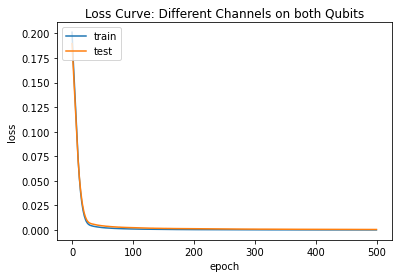

In [46]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Different Channels on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 5.1106e-04 - 233ms/epoch - 33ms/step


In [48]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_diff_mse = tf.math.reduce_mean(fid)
print(fid_diff_mse)

tf.Tensor((0.99558264-3.248299e-05j), shape=(), dtype=complex64)


### <font color='green'>Same Channel on both Qubits</font>

In [59]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [60]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()

    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(phase_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [61]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [82]:
x_train_list = vectors_with_noise[:300]
y_train_list = vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[400:800]
y_val_list = vectors_noise_free[400:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [83]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [84]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.0008)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [85]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=500)

Epoch 1/500
6/6 [==============================] - 2s 64ms/step - loss: 0.2055 - val_loss: 0.1970
Epoch 2/500
6/6 [==============================] - 0s 20ms/step - loss: 0.1918 - val_loss: 0.1869
Epoch 3/500
6/6 [==============================] - 0s 20ms/step - loss: 0.1811 - val_loss: 0.1785
Epoch 4/500
6/6 [==============================] - 0s 24ms/step - loss: 0.1717 - val_loss: 0.1709
Epoch 5/500
6/6 [==============================] - 0s 26ms/step - loss: 0.1630 - val_loss: 0.1633
Epoch 6/500
6/6 [==============================] - 0s 26ms/step - loss: 0.1545 - val_loss: 0.1556
Epoch 7/500
6/6 [==============================] - 0s 20ms/step - loss: 0.1459 - val_loss: 0.1476
Epoch 8/500
6/6 [==============================] - 0s 18ms/step - loss: 0.1371 - val_loss: 0.1394
Epoch 9/500
6/6 [==============================] - 0s 21ms/step - loss: 0.1282 - val_loss: 0.1310
Epoch 10/500
6/6 [==============================] - 0s 21ms/step - loss: 0.1192 - val_loss: 0.1225
Epoch 11/500
6/6 [=

Epoch 84/500
6/6 [==============================] - 0s 23ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 85/500
6/6 [==============================] - 0s 23ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 86/500
6/6 [==============================] - 0s 24ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 87/500
6/6 [==============================] - 0s 22ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 88/500
6/6 [==============================] - 0s 22ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 89/500
6/6 [==============================] - 0s 22ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 90/500
6/6 [==============================] - 0s 21ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 91/500
6/6 [==============================] - 0s 19ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 92/500
6/6 [==============================] - 0s 18ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 93/500
6/6 [==============================] - 0s 20ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 94/5

Epoch 243/500
6/6 [==============================] - 0s 19ms/step - loss: 4.0672e-04 - val_loss: 0.0011
Epoch 244/500
6/6 [==============================] - 0s 19ms/step - loss: 4.0840e-04 - val_loss: 0.0011
Epoch 245/500
6/6 [==============================] - 0s 20ms/step - loss: 4.0752e-04 - val_loss: 0.0011
Epoch 246/500
6/6 [==============================] - 0s 23ms/step - loss: 4.0646e-04 - val_loss: 0.0011
Epoch 247/500
6/6 [==============================] - 0s 26ms/step - loss: 4.0348e-04 - val_loss: 0.0011
Epoch 248/500
6/6 [==============================] - 0s 21ms/step - loss: 3.9861e-04 - val_loss: 0.0011
Epoch 249/500
6/6 [==============================] - 0s 21ms/step - loss: 3.9969e-04 - val_loss: 0.0011
Epoch 250/500
6/6 [==============================] - 0s 19ms/step - loss: 3.9066e-04 - val_loss: 0.0011
Epoch 251/500
6/6 [==============================] - 0s 22ms/step - loss: 3.8840e-04 - val_loss: 0.0010
Epoch 252/500
6/6 [==============================] - 0s 24ms/ste

Epoch 395/500
6/6 [==============================] - 0s 23ms/step - loss: 1.9244e-04 - val_loss: 6.3420e-04
Epoch 396/500
6/6 [==============================] - 0s 24ms/step - loss: 1.8735e-04 - val_loss: 6.3327e-04
Epoch 397/500
6/6 [==============================] - 0s 23ms/step - loss: 1.9039e-04 - val_loss: 6.3001e-04
Epoch 398/500
6/6 [==============================] - 0s 22ms/step - loss: 1.9090e-04 - val_loss: 6.3447e-04
Epoch 399/500
6/6 [==============================] - 0s 22ms/step - loss: 1.8989e-04 - val_loss: 6.2729e-04
Epoch 400/500
6/6 [==============================] - 0s 23ms/step - loss: 1.8706e-04 - val_loss: 6.3072e-04
Epoch 401/500
6/6 [==============================] - 0s 23ms/step - loss: 1.9393e-04 - val_loss: 6.2570e-04
Epoch 402/500
6/6 [==============================] - 0s 25ms/step - loss: 1.8901e-04 - val_loss: 6.2701e-04
Epoch 403/500
6/6 [==============================] - 0s 23ms/step - loss: 1.9002e-04 - val_loss: 6.3472e-04
Epoch 404/500
6/6 [=========

Epoch 471/500
6/6 [==============================] - 0s 22ms/step - loss: 1.4376e-04 - val_loss: 5.3450e-04
Epoch 472/500
6/6 [==============================] - 0s 24ms/step - loss: 1.4299e-04 - val_loss: 5.2712e-04
Epoch 473/500
6/6 [==============================] - 0s 26ms/step - loss: 1.4386e-04 - val_loss: 5.3307e-04
Epoch 474/500
6/6 [==============================] - 0s 26ms/step - loss: 1.4719e-04 - val_loss: 5.2735e-04
Epoch 475/500
6/6 [==============================] - 0s 22ms/step - loss: 1.4217e-04 - val_loss: 5.1779e-04
Epoch 476/500
6/6 [==============================] - 0s 20ms/step - loss: 1.3775e-04 - val_loss: 5.2000e-04
Epoch 477/500
6/6 [==============================] - 0s 20ms/step - loss: 1.3841e-04 - val_loss: 5.3119e-04
Epoch 478/500
6/6 [==============================] - 0s 20ms/step - loss: 1.4139e-04 - val_loss: 5.1759e-04
Epoch 479/500
6/6 [==============================] - 0s 26ms/step - loss: 1.4023e-04 - val_loss: 5.1892e-04
Epoch 480/500
6/6 [=========

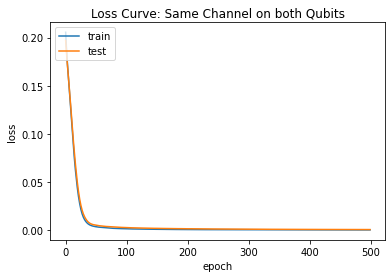

In [86]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Same Channel on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [87]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 5.5021e-04 - 292ms/epoch - 42ms/step


In [88]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_same_mse = tf.math.reduce_mean(fid)
print(fid_same_mse)

tf.Tensor((0.9929829-2.3192393e-05j), shape=(), dtype=complex64)


### <font color='green'>One Channel on One Qubit</font>

In [89]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [90]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()

    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [91]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [92]:
x_train_list = vectors_with_noise[:300]
y_train_list = vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[400:800]
y_val_list = vectors_noise_free[400:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [93]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [94]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [95]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=500)

Epoch 1/500
6/6 [==============================] - 2s 104ms/step - loss: 0.2172 - val_loss: 0.2079
Epoch 2/500
6/6 [==============================] - 0s 25ms/step - loss: 0.1970 - val_loss: 0.1927
Epoch 3/500
6/6 [==============================] - 0s 29ms/step - loss: 0.1823 - val_loss: 0.1804
Epoch 4/500
6/6 [==============================] - 0s 24ms/step - loss: 0.1693 - val_loss: 0.1692
Epoch 5/500
6/6 [==============================] - 0s 20ms/step - loss: 0.1574 - val_loss: 0.1584
Epoch 6/500
6/6 [==============================] - 0s 22ms/step - loss: 0.1453 - val_loss: 0.1472
Epoch 7/500
6/6 [==============================] - 0s 21ms/step - loss: 0.1329 - val_loss: 0.1355
Epoch 8/500
6/6 [==============================] - 0s 20ms/step - loss: 0.1202 - val_loss: 0.1237
Epoch 9/500
6/6 [==============================] - 0s 20ms/step - loss: 0.1075 - val_loss: 0.1119
Epoch 10/500
6/6 [==============================] - 0s 20ms/step - loss: 0.0951 - val_loss: 0.1001
Epoch 11/500
6/6 [

Epoch 84/500
6/6 [==============================] - 0s 26ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 85/500
6/6 [==============================] - 0s 23ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 86/500
6/6 [==============================] - 0s 22ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 87/500
6/6 [==============================] - 0s 19ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 88/500
6/6 [==============================] - 0s 19ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 89/500
6/6 [==============================] - 0s 22ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 90/500
6/6 [==============================] - 0s 20ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 91/500
6/6 [==============================] - 0s 20ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 92/500
6/6 [==============================] - 0s 24ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 93/500
6/6 [==============================] - 0s 25ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 94/5

Epoch 243/500
6/6 [==============================] - 0s 20ms/step - loss: 4.6793e-04 - val_loss: 0.0020
Epoch 244/500
6/6 [==============================] - 0s 21ms/step - loss: 4.7099e-04 - val_loss: 0.0020
Epoch 245/500
6/6 [==============================] - 0s 23ms/step - loss: 4.5931e-04 - val_loss: 0.0019
Epoch 246/500
6/6 [==============================] - 0s 24ms/step - loss: 4.5792e-04 - val_loss: 0.0019
Epoch 247/500
6/6 [==============================] - 0s 23ms/step - loss: 4.6000e-04 - val_loss: 0.0020
Epoch 248/500
6/6 [==============================] - 0s 22ms/step - loss: 4.5844e-04 - val_loss: 0.0019
Epoch 249/500
6/6 [==============================] - 0s 21ms/step - loss: 4.5579e-04 - val_loss: 0.0019
Epoch 250/500
6/6 [==============================] - 0s 23ms/step - loss: 4.5352e-04 - val_loss: 0.0019
Epoch 251/500
6/6 [==============================] - 0s 19ms/step - loss: 4.4875e-04 - val_loss: 0.0019
Epoch 252/500
6/6 [==============================] - 0s 20ms/ste

Epoch 322/500
6/6 [==============================] - 0s 21ms/step - loss: 3.4175e-04 - val_loss: 0.0018
Epoch 323/500
6/6 [==============================] - 0s 20ms/step - loss: 3.4307e-04 - val_loss: 0.0017
Epoch 324/500
6/6 [==============================] - 0s 21ms/step - loss: 3.3705e-04 - val_loss: 0.0018
Epoch 325/500
6/6 [==============================] - 0s 21ms/step - loss: 3.3365e-04 - val_loss: 0.0017
Epoch 326/500
6/6 [==============================] - 0s 20ms/step - loss: 3.3258e-04 - val_loss: 0.0017
Epoch 327/500
6/6 [==============================] - 0s 19ms/step - loss: 3.2911e-04 - val_loss: 0.0017
Epoch 328/500
6/6 [==============================] - 0s 18ms/step - loss: 3.3512e-04 - val_loss: 0.0017
Epoch 329/500
6/6 [==============================] - 0s 18ms/step - loss: 3.4332e-04 - val_loss: 0.0018
Epoch 330/500
6/6 [==============================] - 0s 18ms/step - loss: 3.4200e-04 - val_loss: 0.0017
Epoch 331/500
6/6 [==============================] - 0s 18ms/ste

Epoch 401/500
6/6 [==============================] - 0s 25ms/step - loss: 2.6856e-04 - val_loss: 0.0016
Epoch 402/500
6/6 [==============================] - 0s 26ms/step - loss: 2.6650e-04 - val_loss: 0.0016
Epoch 403/500
6/6 [==============================] - 0s 23ms/step - loss: 2.7180e-04 - val_loss: 0.0016
Epoch 404/500
6/6 [==============================] - 0s 23ms/step - loss: 2.6643e-04 - val_loss: 0.0016
Epoch 405/500
6/6 [==============================] - 0s 18ms/step - loss: 2.6331e-04 - val_loss: 0.0016
Epoch 406/500
6/6 [==============================] - 0s 20ms/step - loss: 2.6754e-04 - val_loss: 0.0016
Epoch 407/500
6/6 [==============================] - 0s 22ms/step - loss: 2.6503e-04 - val_loss: 0.0016
Epoch 408/500
6/6 [==============================] - 0s 24ms/step - loss: 2.6709e-04 - val_loss: 0.0016
Epoch 409/500
6/6 [==============================] - 0s 21ms/step - loss: 2.6241e-04 - val_loss: 0.0016
Epoch 410/500
6/6 [==============================] - 0s 20ms/ste

Epoch 480/500
6/6 [==============================] - 0s 23ms/step - loss: 2.2188e-04 - val_loss: 0.0016
Epoch 481/500
6/6 [==============================] - 0s 22ms/step - loss: 2.2910e-04 - val_loss: 0.0016
Epoch 482/500
6/6 [==============================] - 0s 23ms/step - loss: 2.2163e-04 - val_loss: 0.0015
Epoch 483/500
6/6 [==============================] - 0s 21ms/step - loss: 2.1686e-04 - val_loss: 0.0015
Epoch 484/500
6/6 [==============================] - 0s 19ms/step - loss: 2.1668e-04 - val_loss: 0.0015
Epoch 485/500
6/6 [==============================] - 0s 23ms/step - loss: 2.1656e-04 - val_loss: 0.0015
Epoch 486/500
6/6 [==============================] - 0s 22ms/step - loss: 2.1833e-04 - val_loss: 0.0015
Epoch 487/500
6/6 [==============================] - 0s 22ms/step - loss: 2.1247e-04 - val_loss: 0.0015
Epoch 488/500
6/6 [==============================] - 0s 21ms/step - loss: 2.0985e-04 - val_loss: 0.0015
Epoch 489/500
6/6 [==============================] - 0s 20ms/ste

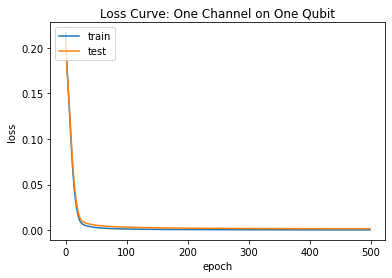

In [96]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: One Channel on One Qubit')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [97]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 0.0015 - 275ms/epoch - 39ms/step


In [98]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_one_mse = tf.math.reduce_mean(fid)
print(fid_one_mse)

tf.Tensor((0.9955662+2.6770262e-05j), shape=(), dtype=complex64)


## <font color='red'>Training the Algorithm (INF)</font>

### <font color='red'>Different Channels on both Qubits</font>

In [196]:
# Generate data
data = generate_Haar_data(2, 2000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [197]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()
    #print(circ)
    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(bit_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [198]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [199]:
x_train_list = vectors_with_noise[:800]
y_train_list = vectors_noise_free[:800]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[800:900]
y_val_list = vectors_noise_free[800:900]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[900:]
y_test_list = vectors_noise_free[900:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [200]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'),    
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

In [201]:
# Compile model
adam_opt = tf.optimizers.Adam(0.0002)
model.compile(optimizer=adam_opt,
              loss=infidelity)

In [202]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=4000)

Epoch 1/4000
8/8 [==============================] - 3s 72ms/step - loss: 0.7642 - val_loss: 0.7461
Epoch 2/4000
8/8 [==============================] - 0s 18ms/step - loss: 0.7403 - val_loss: 0.7236
Epoch 3/4000
8/8 [==============================] - 0s 17ms/step - loss: 0.7170 - val_loss: 0.7009
Epoch 4/4000
8/8 [==============================] - 0s 19ms/step - loss: 0.6923 - val_loss: 0.6777
Epoch 5/4000
8/8 [==============================] - 0s 17ms/step - loss: 0.6707 - val_loss: 0.6577
Epoch 6/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.6499 - val_loss: 0.6363
Epoch 7/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.6273 - val_loss: 0.6137
Epoch 8/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.6059 - val_loss: 0.5960
Epoch 9/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.5865 - val_loss: 0.5779
Epoch 10/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.5670 - val_loss: 0.5594
Epoch 11/

8/8 [==============================] - 0s 18ms/step - loss: 0.2436 - val_loss: 0.2402
Epoch 84/4000
8/8 [==============================] - 0s 18ms/step - loss: 0.2423 - val_loss: 0.2388
Epoch 85/4000
8/8 [==============================] - 0s 17ms/step - loss: 0.2411 - val_loss: 0.2374
Epoch 86/4000
8/8 [==============================] - 0s 19ms/step - loss: 0.2401 - val_loss: 0.2363
Epoch 87/4000
8/8 [==============================] - 0s 18ms/step - loss: 0.2396 - val_loss: 0.2358
Epoch 88/4000
8/8 [==============================] - 0s 19ms/step - loss: 0.2390 - val_loss: 0.2348
Epoch 89/4000
8/8 [==============================] - 0s 18ms/step - loss: 0.2380 - val_loss: 0.2337
Epoch 90/4000
8/8 [==============================] - 0s 19ms/step - loss: 0.2370 - val_loss: 0.2325
Epoch 91/4000
8/8 [==============================] - 0s 19ms/step - loss: 0.2358 - val_loss: 0.2312
Epoch 92/4000
8/8 [==============================] - 0s 19ms/step - loss: 0.2351 - val_loss: 0.2306
Epoch 93/4000


8/8 [==============================] - 0s 15ms/step - loss: 0.1891 - val_loss: 0.1819
Epoch 165/4000
8/8 [==============================] - 0s 17ms/step - loss: 0.1886 - val_loss: 0.1815
Epoch 166/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.1881 - val_loss: 0.1810
Epoch 167/4000
8/8 [==============================] - 0s 19ms/step - loss: 0.1876 - val_loss: 0.1805
Epoch 168/4000
8/8 [==============================] - 0s 20ms/step - loss: 0.1870 - val_loss: 0.1799
Epoch 169/4000
8/8 [==============================] - 0s 21ms/step - loss: 0.1863 - val_loss: 0.1794
Epoch 170/4000
8/8 [==============================] - 0s 19ms/step - loss: 0.1857 - val_loss: 0.1788
Epoch 171/4000
8/8 [==============================] - 0s 19ms/step - loss: 0.1851 - val_loss: 0.1788
Epoch 172/4000
8/8 [==============================] - 0s 20ms/step - loss: 0.1851 - val_loss: 0.1788
Epoch 173/4000
8/8 [==============================] - 0s 20ms/step - loss: 0.1850 - val_loss: 0.1786
Epoch

8/8 [==============================] - 0s 17ms/step - loss: 0.1665 - val_loss: 0.1619
Epoch 246/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.1661 - val_loss: 0.1613
Epoch 247/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.1655 - val_loss: 0.1607
Epoch 248/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.1649 - val_loss: 0.1601
Epoch 249/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.1643 - val_loss: 0.1594
Epoch 250/4000
8/8 [==============================] - 0s 19ms/step - loss: 0.1637 - val_loss: 0.1588
Epoch 251/4000
8/8 [==============================] - 0s 18ms/step - loss: 0.1631 - val_loss: 0.1582
Epoch 252/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.1625 - val_loss: 0.1577
Epoch 253/4000
8/8 [==============================] - 0s 17ms/step - loss: 0.1620 - val_loss: 0.1571
Epoch 254/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.1614 - val_loss: 0.1562
Epoch

8/8 [==============================] - 0s 15ms/step - loss: 0.1573 - val_loss: 0.1490
Epoch 327/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.1567 - val_loss: 0.1486
Epoch 328/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.1563 - val_loss: 0.1483
Epoch 329/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.1558 - val_loss: 0.1479
Epoch 330/4000
8/8 [==============================] - 0s 17ms/step - loss: 0.1554 - val_loss: 0.1477
Epoch 331/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.1555 - val_loss: 0.1478
Epoch 332/4000
8/8 [==============================] - 0s 17ms/step - loss: 0.1557 - val_loss: 0.1478
Epoch 333/4000
8/8 [==============================] - 0s 17ms/step - loss: 0.1556 - val_loss: 0.1476
Epoch 334/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.1555 - val_loss: 0.1475
Epoch 335/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.1552 - val_loss: 0.1472
Epoch

8/8 [==============================] - 0s 21ms/step - loss: 0.1352 - val_loss: 0.1307
Epoch 408/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.1350 - val_loss: 0.1306
Epoch 409/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.1348 - val_loss: 0.1304
Epoch 410/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.1345 - val_loss: 0.1302
Epoch 411/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.1343 - val_loss: 0.1300
Epoch 412/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.1341 - val_loss: 0.1298
Epoch 413/4000
8/8 [==============================] - 0s 20ms/step - loss: 0.1339 - val_loss: 0.1296
Epoch 414/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.1337 - val_loss: 0.1294
Epoch 415/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.1335 - val_loss: 0.1293
Epoch 416/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.1333 - val_loss: 0.1291
Epoch

8/8 [==============================] - 0s 16ms/step - loss: 0.1336 - val_loss: 0.1270
Epoch 489/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.1330 - val_loss: 0.1263
Epoch 490/4000
8/8 [==============================] - 0s 17ms/step - loss: 0.1325 - val_loss: 0.1260
Epoch 491/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.1321 - val_loss: 0.1256
Epoch 492/4000
8/8 [==============================] - 0s 19ms/step - loss: 0.1317 - val_loss: 0.1253
Epoch 493/4000
8/8 [==============================] - 0s 18ms/step - loss: 0.1312 - val_loss: 0.1249
Epoch 494/4000
8/8 [==============================] - 0s 19ms/step - loss: 0.1308 - val_loss: 0.1245
Epoch 495/4000
8/8 [==============================] - 0s 20ms/step - loss: 0.1304 - val_loss: 0.1241
Epoch 496/4000
8/8 [==============================] - 0s 18ms/step - loss: 0.1300 - val_loss: 0.1238
Epoch 497/4000
8/8 [==============================] - 0s 18ms/step - loss: 0.1310 - val_loss: 0.1250
Epoch

8/8 [==============================] - 0s 20ms/step - loss: 0.1174 - val_loss: 0.1150
Epoch 570/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.1170 - val_loss: 0.1147
Epoch 571/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.1165 - val_loss: 0.1141
Epoch 572/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.1159 - val_loss: 0.1136
Epoch 573/4000
8/8 [==============================] - 0s 18ms/step - loss: 0.1154 - val_loss: 0.1131
Epoch 574/4000
8/8 [==============================] - 0s 19ms/step - loss: 0.1147 - val_loss: 0.1121
Epoch 575/4000
8/8 [==============================] - 0s 17ms/step - loss: 0.1137 - val_loss: 0.1114
Epoch 576/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.1131 - val_loss: 0.1108
Epoch 577/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.1125 - val_loss: 0.1103
Epoch 578/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.1121 - val_loss: 0.1100
Epoch

8/8 [==============================] - 0s 19ms/step - loss: 0.0972 - val_loss: 0.0966
Epoch 651/4000
8/8 [==============================] - 0s 19ms/step - loss: 0.0970 - val_loss: 0.0964
Epoch 652/4000
8/8 [==============================] - 0s 19ms/step - loss: 0.0969 - val_loss: 0.0962
Epoch 653/4000
8/8 [==============================] - 0s 18ms/step - loss: 0.0968 - val_loss: 0.0962
Epoch 654/4000
8/8 [==============================] - 0s 19ms/step - loss: 0.0968 - val_loss: 0.0963
Epoch 655/4000
8/8 [==============================] - 0s 18ms/step - loss: 0.0979 - val_loss: 0.0985
Epoch 656/4000
8/8 [==============================] - 0s 20ms/step - loss: 0.1000 - val_loss: 0.0999
Epoch 657/4000
8/8 [==============================] - 0s 18ms/step - loss: 0.1009 - val_loss: 0.1003
Epoch 658/4000
8/8 [==============================] - 0s 17ms/step - loss: 0.1011 - val_loss: 0.1002
Epoch 659/4000
8/8 [==============================] - 0s 18ms/step - loss: 0.1009 - val_loss: 0.0999
Epoch

8/8 [==============================] - 0s 12ms/step - loss: 0.0911 - val_loss: 0.0900
Epoch 732/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0906 - val_loss: 0.0897
Epoch 733/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0903 - val_loss: 0.0905
Epoch 734/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0915 - val_loss: 0.0922
Epoch 735/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0928 - val_loss: 0.0930
Epoch 736/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0931 - val_loss: 0.0919
Epoch 737/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0923 - val_loss: 0.0919
Epoch 738/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0930 - val_loss: 0.0924
Epoch 739/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0934 - val_loss: 0.0926
Epoch 740/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0934 - val_loss: 0.0921
Epoch

8/8 [==============================] - 0s 18ms/step - loss: 0.0844 - val_loss: 0.0868
Epoch 813/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0842 - val_loss: 0.0866
Epoch 814/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0845 - val_loss: 0.0879
Epoch 815/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0861 - val_loss: 0.0898
Epoch 816/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0875 - val_loss: 0.0908
Epoch 817/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0880 - val_loss: 0.0909
Epoch 818/4000
8/8 [==============================] - 0s 18ms/step - loss: 0.0879 - val_loss: 0.0907
Epoch 819/4000
8/8 [==============================] - 0s 18ms/step - loss: 0.0876 - val_loss: 0.0902
Epoch 820/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0872 - val_loss: 0.0897
Epoch 821/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0868 - val_loss: 0.0893
Epoch

8/8 [==============================] - 0s 16ms/step - loss: 0.0728 - val_loss: 0.0747
Epoch 894/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0726 - val_loss: 0.0747
Epoch 895/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0726 - val_loss: 0.0750
Epoch 896/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0727 - val_loss: 0.0751
Epoch 897/4000
8/8 [==============================] - 0s 17ms/step - loss: 0.0727 - val_loss: 0.0751
Epoch 898/4000
8/8 [==============================] - 0s 19ms/step - loss: 0.0726 - val_loss: 0.0749
Epoch 899/4000
8/8 [==============================] - 0s 17ms/step - loss: 0.0725 - val_loss: 0.0748
Epoch 900/4000
8/8 [==============================] - 0s 17ms/step - loss: 0.0723 - val_loss: 0.0745
Epoch 901/4000
8/8 [==============================] - 0s 20ms/step - loss: 0.0721 - val_loss: 0.0743
Epoch 902/4000
8/8 [==============================] - 0s 20ms/step - loss: 0.0720 - val_loss: 0.0741
Epoch

8/8 [==============================] - 0s 14ms/step - loss: 0.0739 - val_loss: 0.0764
Epoch 975/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0732 - val_loss: 0.0761
Epoch 976/4000
8/8 [==============================] - 0s 17ms/step - loss: 0.0729 - val_loss: 0.0759
Epoch 977/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0724 - val_loss: 0.0749
Epoch 978/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0713 - val_loss: 0.0739
Epoch 979/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0704 - val_loss: 0.0731
Epoch 980/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0695 - val_loss: 0.0701
Epoch 981/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0666 - val_loss: 0.0688
Epoch 982/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0668 - val_loss: 0.0692
Epoch 983/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0673 - val_loss: 0.0694
Epoch

8/8 [==============================] - 0s 18ms/step - loss: 0.1134 - val_loss: 0.1155
Epoch 1055/4000
8/8 [==============================] - 0s 17ms/step - loss: 0.1114 - val_loss: 0.1137
Epoch 1056/4000
8/8 [==============================] - 0s 17ms/step - loss: 0.1097 - val_loss: 0.1120
Epoch 1057/4000
8/8 [==============================] - 0s 18ms/step - loss: 0.1080 - val_loss: 0.1104
Epoch 1058/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.1066 - val_loss: 0.1090
Epoch 1059/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.1052 - val_loss: 0.1077
Epoch 1060/4000
8/8 [==============================] - 0s 18ms/step - loss: 0.1038 - val_loss: 0.1063
Epoch 1061/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.1024 - val_loss: 0.1050
Epoch 1062/4000
8/8 [==============================] - 0s 18ms/step - loss: 0.1011 - val_loss: 0.1037
Epoch 1063/4000
8/8 [==============================] - 0s 20ms/step - loss: 0.0999 - val_loss: 0.1

8/8 [==============================] - 0s 19ms/step - loss: 0.0741 - val_loss: 0.0813
Epoch 1135/4000
8/8 [==============================] - 0s 19ms/step - loss: 0.0737 - val_loss: 0.0808
Epoch 1136/4000
8/8 [==============================] - 0s 18ms/step - loss: 0.0734 - val_loss: 0.0804
Epoch 1137/4000
8/8 [==============================] - 0s 19ms/step - loss: 0.0730 - val_loss: 0.0799
Epoch 1138/4000
8/8 [==============================] - 0s 20ms/step - loss: 0.0726 - val_loss: 0.0794
Epoch 1139/4000
8/8 [==============================] - 0s 21ms/step - loss: 0.0722 - val_loss: 0.0790
Epoch 1140/4000
8/8 [==============================] - 0s 19ms/step - loss: 0.0718 - val_loss: 0.0786
Epoch 1141/4000
8/8 [==============================] - 0s 19ms/step - loss: 0.0715 - val_loss: 0.0782
Epoch 1142/4000
8/8 [==============================] - 0s 20ms/step - loss: 0.0712 - val_loss: 0.0778
Epoch 1143/4000
8/8 [==============================] - 0s 18ms/step - loss: 0.0709 - val_loss: 0.0

8/8 [==============================] - 0s 17ms/step - loss: 0.0686 - val_loss: 0.0774
Epoch 1215/4000
8/8 [==============================] - 0s 18ms/step - loss: 0.0700 - val_loss: 0.0781
Epoch 1216/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0702 - val_loss: 0.0784
Epoch 1217/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0719 - val_loss: 0.0817
Epoch 1218/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0741 - val_loss: 0.0831
Epoch 1219/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0746 - val_loss: 0.0831
Epoch 1220/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0744 - val_loss: 0.0825
Epoch 1221/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0737 - val_loss: 0.0816
Epoch 1222/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0728 - val_loss: 0.0807
Epoch 1223/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0720 - val_loss: 0.0

8/8 [==============================] - 0s 16ms/step - loss: 0.0868 - val_loss: 0.0936
Epoch 1295/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0863 - val_loss: 0.0928
Epoch 1296/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0855 - val_loss: 0.0919
Epoch 1297/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0845 - val_loss: 0.0908
Epoch 1298/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0834 - val_loss: 0.0896
Epoch 1299/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0823 - val_loss: 0.0885
Epoch 1300/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0813 - val_loss: 0.0874
Epoch 1301/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0802 - val_loss: 0.0863
Epoch 1302/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0792 - val_loss: 0.0854
Epoch 1303/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0787 - val_loss: 0.0

8/8 [==============================] - 0s 15ms/step - loss: 0.0681 - val_loss: 0.0733
Epoch 1375/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0676 - val_loss: 0.0727
Epoch 1376/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0672 - val_loss: 0.0721
Epoch 1377/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0666 - val_loss: 0.0715
Epoch 1378/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0660 - val_loss: 0.0709
Epoch 1379/4000
8/8 [==============================] - 0s 11ms/step - loss: 0.0652 - val_loss: 0.0694
Epoch 1380/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0641 - val_loss: 0.0686
Epoch 1381/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0636 - val_loss: 0.0680
Epoch 1382/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0632 - val_loss: 0.0675
Epoch 1383/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0627 - val_loss: 0.0

8/8 [==============================] - 0s 13ms/step - loss: 0.0520 - val_loss: 0.0558
Epoch 1455/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0521 - val_loss: 0.0558
Epoch 1456/4000
8/8 [==============================] - 0s 11ms/step - loss: 0.0521 - val_loss: 0.0557
Epoch 1457/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0520 - val_loss: 0.0556
Epoch 1458/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0520 - val_loss: 0.0557
Epoch 1459/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0519 - val_loss: 0.0555
Epoch 1460/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0518 - val_loss: 0.0555
Epoch 1461/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0516 - val_loss: 0.0553
Epoch 1462/4000
8/8 [==============================] - 0s 11ms/step - loss: 0.0514 - val_loss: 0.0551
Epoch 1463/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0513 - val_loss: 0.0

8/8 [==============================] - 0s 15ms/step - loss: 0.0473 - val_loss: 0.0523
Epoch 1535/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0489 - val_loss: 0.0533
Epoch 1536/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0495 - val_loss: 0.0534
Epoch 1537/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0492 - val_loss: 0.0527
Epoch 1538/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0484 - val_loss: 0.0521
Epoch 1539/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0479 - val_loss: 0.0518
Epoch 1540/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0476 - val_loss: 0.0511
Epoch 1541/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0475 - val_loss: 0.0507
Epoch 1542/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0473 - val_loss: 0.0504
Epoch 1543/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0470 - val_loss: 0.0

8/8 [==============================] - 0s 13ms/step - loss: 0.0562 - val_loss: 0.0556
Epoch 1615/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0559 - val_loss: 0.0553
Epoch 1616/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0556 - val_loss: 0.0550
Epoch 1617/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0553 - val_loss: 0.0547
Epoch 1618/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0551 - val_loss: 0.0546
Epoch 1619/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0549 - val_loss: 0.0544
Epoch 1620/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0547 - val_loss: 0.0542
Epoch 1621/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0545 - val_loss: 0.0540
Epoch 1622/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0543 - val_loss: 0.0538
Epoch 1623/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0540 - val_loss: 0.0

8/8 [==============================] - 0s 17ms/step - loss: 0.0475 - val_loss: 0.0499
Epoch 1695/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0476 - val_loss: 0.0499
Epoch 1696/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0476 - val_loss: 0.0499
Epoch 1697/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0475 - val_loss: 0.0497
Epoch 1698/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0474 - val_loss: 0.0496
Epoch 1699/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0472 - val_loss: 0.0494
Epoch 1700/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0470 - val_loss: 0.0492
Epoch 1701/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0469 - val_loss: 0.0491
Epoch 1702/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0467 - val_loss: 0.0489
Epoch 1703/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0466 - val_loss: 0.0

8/8 [==============================] - 0s 15ms/step - loss: 0.0437 - val_loss: 0.0447
Epoch 1775/4000
8/8 [==============================] - 0s 17ms/step - loss: 0.0436 - val_loss: 0.0446
Epoch 1776/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0435 - val_loss: 0.0444
Epoch 1777/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0433 - val_loss: 0.0442
Epoch 1778/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0430 - val_loss: 0.0439
Epoch 1779/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0429 - val_loss: 0.0440
Epoch 1780/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0429 - val_loss: 0.0438
Epoch 1781/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0428 - val_loss: 0.0437
Epoch 1782/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0425 - val_loss: 0.0434
Epoch 1783/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0425 - val_loss: 0.0

8/8 [==============================] - 0s 15ms/step - loss: 0.0396 - val_loss: 0.0417
Epoch 1855/4000
8/8 [==============================] - 0s 11ms/step - loss: 0.0394 - val_loss: 0.0414
Epoch 1856/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0392 - val_loss: 0.0412
Epoch 1857/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0390 - val_loss: 0.0410
Epoch 1858/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0389 - val_loss: 0.0408
Epoch 1859/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0387 - val_loss: 0.0406
Epoch 1860/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0385 - val_loss: 0.0404
Epoch 1861/4000
8/8 [==============================] - 0s 11ms/step - loss: 0.0384 - val_loss: 0.0403
Epoch 1862/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0382 - val_loss: 0.0401
Epoch 1863/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0381 - val_loss: 0.0

8/8 [==============================] - 0s 14ms/step - loss: 0.0339 - val_loss: 0.0359
Epoch 1935/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0338 - val_loss: 0.0358
Epoch 1936/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0337 - val_loss: 0.0357
Epoch 1937/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0336 - val_loss: 0.0356
Epoch 1938/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0335 - val_loss: 0.0355
Epoch 1939/4000
8/8 [==============================] - 0s 11ms/step - loss: 0.0335 - val_loss: 0.0354
Epoch 1940/4000
8/8 [==============================] - 0s 11ms/step - loss: 0.0334 - val_loss: 0.0354
Epoch 1941/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0332 - val_loss: 0.0354
Epoch 1942/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0332 - val_loss: 0.0354
Epoch 1943/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0331 - val_loss: 0.0

8/8 [==============================] - 0s 14ms/step - loss: 0.0307 - val_loss: 0.0326
Epoch 2015/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0307 - val_loss: 0.0326
Epoch 2016/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0307 - val_loss: 0.0325
Epoch 2017/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0306 - val_loss: 0.0324
Epoch 2018/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0305 - val_loss: 0.0324
Epoch 2019/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0305 - val_loss: 0.0323
Epoch 2020/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0304 - val_loss: 0.0323
Epoch 2021/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0303 - val_loss: 0.0322
Epoch 2022/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0303 - val_loss: 0.0321
Epoch 2023/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0302 - val_loss: 0.0

8/8 [==============================] - 0s 17ms/step - loss: 0.0440 - val_loss: 0.0471
Epoch 2095/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0427 - val_loss: 0.0449
Epoch 2096/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0411 - val_loss: 0.0441
Epoch 2097/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0404 - val_loss: 0.0435
Epoch 2098/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0398 - val_loss: 0.0428
Epoch 2099/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0392 - val_loss: 0.0422
Epoch 2100/4000
8/8 [==============================] - 0s 17ms/step - loss: 0.0385 - val_loss: 0.0416
Epoch 2101/4000
8/8 [==============================] - 0s 17ms/step - loss: 0.0385 - val_loss: 0.0424
Epoch 2102/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0388 - val_loss: 0.0425
Epoch 2103/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0387 - val_loss: 0.0

8/8 [==============================] - 0s 16ms/step - loss: 0.0328 - val_loss: 0.0350
Epoch 2175/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0327 - val_loss: 0.0348
Epoch 2176/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0326 - val_loss: 0.0347
Epoch 2177/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0326 - val_loss: 0.0347
Epoch 2178/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0325 - val_loss: 0.0346
Epoch 2179/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0324 - val_loss: 0.0346
Epoch 2180/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0324 - val_loss: 0.0346
Epoch 2181/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0323 - val_loss: 0.0347
Epoch 2182/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0322 - val_loss: 0.0346
Epoch 2183/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0322 - val_loss: 0.0

8/8 [==============================] - 0s 13ms/step - loss: 0.0558 - val_loss: 0.0580
Epoch 2255/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0548 - val_loss: 0.0570
Epoch 2256/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0537 - val_loss: 0.0560
Epoch 2257/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0527 - val_loss: 0.0550
Epoch 2258/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0519 - val_loss: 0.0542
Epoch 2259/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0510 - val_loss: 0.0533
Epoch 2260/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0502 - val_loss: 0.0526
Epoch 2261/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0495 - val_loss: 0.0519
Epoch 2262/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0487 - val_loss: 0.0512
Epoch 2263/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0480 - val_loss: 0.0

8/8 [==============================] - 0s 12ms/step - loss: 0.0316 - val_loss: 0.0339
Epoch 2335/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0315 - val_loss: 0.0338
Epoch 2336/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0314 - val_loss: 0.0337
Epoch 2337/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0313 - val_loss: 0.0336
Epoch 2338/4000
8/8 [==============================] - 0s 11ms/step - loss: 0.0312 - val_loss: 0.0335
Epoch 2339/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0311 - val_loss: 0.0336
Epoch 2340/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0331 - val_loss: 0.0378
Epoch 2341/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0369 - val_loss: 0.0408
Epoch 2342/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0392 - val_loss: 0.0421
Epoch 2343/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0399 - val_loss: 0.0

8/8 [==============================] - 0s 14ms/step - loss: 0.0319 - val_loss: 0.0342
Epoch 2415/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0311 - val_loss: 0.0340
Epoch 2416/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0310 - val_loss: 0.0340
Epoch 2417/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0310 - val_loss: 0.0340
Epoch 2418/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0308 - val_loss: 0.0338
Epoch 2419/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0307 - val_loss: 0.0337
Epoch 2420/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0304 - val_loss: 0.0334
Epoch 2421/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0302 - val_loss: 0.0333
Epoch 2422/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0300 - val_loss: 0.0330
Epoch 2423/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0298 - val_loss: 0.0

8/8 [==============================] - 0s 15ms/step - loss: 0.0344 - val_loss: 0.0389
Epoch 2495/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0349 - val_loss: 0.0389
Epoch 2496/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0349 - val_loss: 0.0387
Epoch 2497/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0345 - val_loss: 0.0383
Epoch 2498/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0341 - val_loss: 0.0378
Epoch 2499/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0338 - val_loss: 0.0378
Epoch 2500/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0338 - val_loss: 0.0380
Epoch 2501/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0341 - val_loss: 0.0380
Epoch 2502/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0340 - val_loss: 0.0377
Epoch 2503/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0337 - val_loss: 0.0

8/8 [==============================] - 0s 14ms/step - loss: 0.0461 - val_loss: 0.0460
Epoch 2575/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0445 - val_loss: 0.0448
Epoch 2576/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0432 - val_loss: 0.0437
Epoch 2577/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0421 - val_loss: 0.0427
Epoch 2578/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0410 - val_loss: 0.0418
Epoch 2579/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0401 - val_loss: 0.0410
Epoch 2580/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0393 - val_loss: 0.0403
Epoch 2581/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0385 - val_loss: 0.0396
Epoch 2582/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0378 - val_loss: 0.0390
Epoch 2583/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0372 - val_loss: 0.0

8/8 [==============================] - 0s 14ms/step - loss: 0.0303 - val_loss: 0.0319
Epoch 2655/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0301 - val_loss: 0.0316
Epoch 2656/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0297 - val_loss: 0.0313
Epoch 2657/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0302 - val_loss: 0.0345
Epoch 2658/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0326 - val_loss: 0.0368
Epoch 2659/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0339 - val_loss: 0.0376
Epoch 2660/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0341 - val_loss: 0.0375
Epoch 2661/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0338 - val_loss: 0.0370
Epoch 2662/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0333 - val_loss: 0.0364
Epoch 2663/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0328 - val_loss: 0.0

8/8 [==============================] - 0s 14ms/step - loss: 0.0274 - val_loss: 0.0293
Epoch 2735/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0272 - val_loss: 0.0292
Epoch 2736/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0271 - val_loss: 0.0290
Epoch 2737/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0269 - val_loss: 0.0289
Epoch 2738/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0268 - val_loss: 0.0287
Epoch 2739/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0266 - val_loss: 0.0286
Epoch 2740/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0265 - val_loss: 0.0285
Epoch 2741/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0264 - val_loss: 0.0284
Epoch 2742/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0263 - val_loss: 0.0283
Epoch 2743/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0262 - val_loss: 0.0

8/8 [==============================] - 0s 18ms/step - loss: 0.0229 - val_loss: 0.0244
Epoch 2815/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0231 - val_loss: 0.0246
Epoch 2816/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0268 - val_loss: 0.0329
Epoch 2817/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0360 - val_loss: 0.0394
Epoch 2818/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0407 - val_loss: 0.0416
Epoch 2819/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0418 - val_loss: 0.0416
Epoch 2820/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0413 - val_loss: 0.0405
Epoch 2821/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0399 - val_loss: 0.0390
Epoch 2822/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0385 - val_loss: 0.0375
Epoch 2823/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0370 - val_loss: 0.0

8/8 [==============================] - 0s 13ms/step - loss: 0.0234 - val_loss: 0.0239
Epoch 2895/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0232 - val_loss: 0.0237
Epoch 2896/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0231 - val_loss: 0.0236
Epoch 2897/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0229 - val_loss: 0.0235
Epoch 2898/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0239 - val_loss: 0.0301
Epoch 2899/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0365 - val_loss: 0.0444
Epoch 2900/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0483 - val_loss: 0.0514
Epoch 2901/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0530 - val_loss: 0.0531
Epoch 2902/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0536 - val_loss: 0.0524
Epoch 2903/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0524 - val_loss: 0.0

8/8 [==============================] - 0s 14ms/step - loss: 0.0225 - val_loss: 0.0231
Epoch 2975/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0224 - val_loss: 0.0230
Epoch 2976/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0224 - val_loss: 0.0229
Epoch 2977/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0223 - val_loss: 0.0229
Epoch 2978/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0222 - val_loss: 0.0228
Epoch 2979/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0221 - val_loss: 0.0227
Epoch 2980/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0221 - val_loss: 0.0227
Epoch 2981/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0221 - val_loss: 0.0227
Epoch 2982/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0220 - val_loss: 0.0226
Epoch 2983/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0220 - val_loss: 0.0

8/8 [==============================] - 0s 13ms/step - loss: 0.0253 - val_loss: 0.0246
Epoch 3055/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0251 - val_loss: 0.0248
Epoch 3056/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0252 - val_loss: 0.0251
Epoch 3057/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0254 - val_loss: 0.0252
Epoch 3058/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0254 - val_loss: 0.0251
Epoch 3059/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0252 - val_loss: 0.0250
Epoch 3060/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0251 - val_loss: 0.0248
Epoch 3061/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0249 - val_loss: 0.0246
Epoch 3062/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0248 - val_loss: 0.0245
Epoch 3063/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0246 - val_loss: 0.0

8/8 [==============================] - 0s 15ms/step - loss: 0.0355 - val_loss: 0.0367
Epoch 3135/4000
8/8 [==============================] - 0s 17ms/step - loss: 0.0369 - val_loss: 0.0367
Epoch 3136/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0365 - val_loss: 0.0358
Epoch 3137/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0354 - val_loss: 0.0346
Epoch 3138/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0342 - val_loss: 0.0334
Epoch 3139/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0329 - val_loss: 0.0320
Epoch 3140/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0316 - val_loss: 0.0308
Epoch 3141/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0305 - val_loss: 0.0297
Epoch 3142/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0294 - val_loss: 0.0288
Epoch 3143/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0285 - val_loss: 0.0

8/8 [==============================] - 0s 12ms/step - loss: 0.0190 - val_loss: 0.0198
Epoch 3215/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0189 - val_loss: 0.0197
Epoch 3216/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0188 - val_loss: 0.0197
Epoch 3217/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0188 - val_loss: 0.0196
Epoch 3218/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0188 - val_loss: 0.0196
Epoch 3219/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0187 - val_loss: 0.0196
Epoch 3220/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0187 - val_loss: 0.0196
Epoch 3221/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0186 - val_loss: 0.0195
Epoch 3222/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0186 - val_loss: 0.0201
Epoch 3223/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0192 - val_loss: 0.0

8/8 [==============================] - 0s 14ms/step - loss: 0.0173 - val_loss: 0.0184
Epoch 3295/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0173 - val_loss: 0.0184
Epoch 3296/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0172 - val_loss: 0.0183
Epoch 3297/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0171 - val_loss: 0.0182
Epoch 3298/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0170 - val_loss: 0.0181
Epoch 3299/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0170 - val_loss: 0.0182
Epoch 3300/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0170 - val_loss: 0.0182
Epoch 3301/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0169 - val_loss: 0.0182
Epoch 3302/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0169 - val_loss: 0.0182
Epoch 3303/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0168 - val_loss: 0.0

8/8 [==============================] - 0s 15ms/step - loss: 0.0150 - val_loss: 0.0162
Epoch 3375/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0150 - val_loss: 0.0162
Epoch 3376/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0149 - val_loss: 0.0162
Epoch 3377/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0149 - val_loss: 0.0162
Epoch 3378/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0149 - val_loss: 0.0161
Epoch 3379/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0148 - val_loss: 0.0161
Epoch 3380/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0148 - val_loss: 0.0161
Epoch 3381/4000
8/8 [==============================] - 0s 11ms/step - loss: 0.0148 - val_loss: 0.0161
Epoch 3382/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0147 - val_loss: 0.0160
Epoch 3383/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0147 - val_loss: 0.0

8/8 [==============================] - 0s 17ms/step - loss: 0.0263 - val_loss: 0.0266
Epoch 3455/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0249 - val_loss: 0.0249
Epoch 3456/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0229 - val_loss: 0.0229
Epoch 3457/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0209 - val_loss: 0.0212
Epoch 3458/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0193 - val_loss: 0.0197
Epoch 3459/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0179 - val_loss: 0.0187
Epoch 3460/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0168 - val_loss: 0.0178
Epoch 3461/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0161 - val_loss: 0.0173
Epoch 3462/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0157 - val_loss: 0.0182
Epoch 3463/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0172 - val_loss: 0.0

8/8 [==============================] - 0s 13ms/step - loss: 0.0124 - val_loss: 0.0144
Epoch 3535/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0123 - val_loss: 0.0143
Epoch 3536/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0123 - val_loss: 0.0143
Epoch 3537/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0122 - val_loss: 0.0142
Epoch 3538/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0121 - val_loss: 0.0142
Epoch 3539/4000
8/8 [==============================] - 0s 17ms/step - loss: 0.0121 - val_loss: 0.0141
Epoch 3540/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0122 - val_loss: 0.0141
Epoch 3541/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0122 - val_loss: 0.0142
Epoch 3542/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0121 - val_loss: 0.0141
Epoch 3543/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0121 - val_loss: 0.0

8/8 [==============================] - 0s 11ms/step - loss: 0.0140 - val_loss: 0.0163
Epoch 3615/4000
8/8 [==============================] - 0s 11ms/step - loss: 0.0143 - val_loss: 0.0163
Epoch 3616/4000
8/8 [==============================] - 0s 10ms/step - loss: 0.0143 - val_loss: 0.0162
Epoch 3617/4000
8/8 [==============================] - 0s 10ms/step - loss: 0.0141 - val_loss: 0.0159
Epoch 3618/4000
8/8 [==============================] - 0s 10ms/step - loss: 0.0138 - val_loss: 0.0157
Epoch 3619/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0136 - val_loss: 0.0155
Epoch 3620/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0134 - val_loss: 0.0153
Epoch 3621/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0133 - val_loss: 0.0152
Epoch 3622/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0131 - val_loss: 0.0151
Epoch 3623/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0130 - val_loss: 0.0

8/8 [==============================] - 0s 15ms/step - loss: 0.0169 - val_loss: 0.0182
Epoch 3695/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0161 - val_loss: 0.0174
Epoch 3696/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0153 - val_loss: 0.0167
Epoch 3697/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0147 - val_loss: 0.0161
Epoch 3698/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0142 - val_loss: 0.0157
Epoch 3699/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0138 - val_loss: 0.0154
Epoch 3700/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0136 - val_loss: 0.0152
Epoch 3701/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0134 - val_loss: 0.0150
Epoch 3702/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0132 - val_loss: 0.0148
Epoch 3703/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0131 - val_loss: 0.0

8/8 [==============================] - 0s 15ms/step - loss: 0.0101 - val_loss: 0.0120
Epoch 3775/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0101 - val_loss: 0.0119
Epoch 3776/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0100 - val_loss: 0.0119
Epoch 3777/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0100 - val_loss: 0.0119
Epoch 3778/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0100 - val_loss: 0.0118
Epoch 3779/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0100 - val_loss: 0.0118
Epoch 3780/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0100 - val_loss: 0.0118
Epoch 3781/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0100 - val_loss: 0.0118
Epoch 3782/4000
8/8 [==============================] - 0s 16ms/step - loss: 0.0099 - val_loss: 0.0118
Epoch 3783/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0099 - val_loss: 0.0

8/8 [==============================] - 0s 12ms/step - loss: 0.0091 - val_loss: 0.0110
Epoch 3855/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0091 - val_loss: 0.0110
Epoch 3856/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0090 - val_loss: 0.0110
Epoch 3857/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0090 - val_loss: 0.0109
Epoch 3858/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0090 - val_loss: 0.0109
Epoch 3859/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0090 - val_loss: 0.0109
Epoch 3860/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0089 - val_loss: 0.0109
Epoch 3861/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0089 - val_loss: 0.0108
Epoch 3862/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0089 - val_loss: 0.0108
Epoch 3863/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0088 - val_loss: 0.0

8/8 [==============================] - 0s 14ms/step - loss: 0.0089 - val_loss: 0.0111
Epoch 3935/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0088 - val_loss: 0.0110
Epoch 3936/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0088 - val_loss: 0.0110
Epoch 3937/4000
8/8 [==============================] - 0s 15ms/step - loss: 0.0087 - val_loss: 0.0109
Epoch 3938/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0087 - val_loss: 0.0109
Epoch 3939/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0086 - val_loss: 0.0109
Epoch 3940/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0086 - val_loss: 0.0108
Epoch 3941/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0085 - val_loss: 0.0107
Epoch 3942/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0085 - val_loss: 0.0107
Epoch 3943/4000
8/8 [==============================] - 0s 14ms/step - loss: 0.0085 - val_loss: 0.0

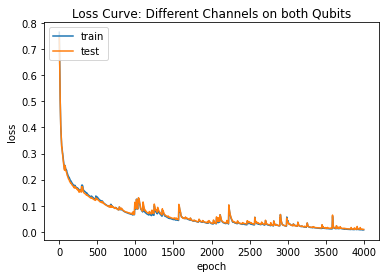

In [203]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Different Channels on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [204]:
score = model.evaluate(x_test,  y_test, verbose=2)

35/35 - 0s - loss: 0.0098 - 453ms/epoch - 13ms/step


In [205]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_both_inf = tf.math.reduce_mean(fid)
print(fid_both_inf)

tf.Tensor((0.99020153-1.0135817e-05j), shape=(), dtype=complex64)


### <font color='red'>Same Channel on both Qubits</font>

In [222]:
# Generate data
data = generate_Haar_data(2, 2000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [223]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()
    #print(circ)
    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(phase_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [224]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [225]:
x_train_list = vectors_with_noise[:900]
y_train_list = vectors_noise_free[:900]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[900:1200]
y_val_list = vectors_noise_free[900:1200]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[1200:]
y_test_list = vectors_noise_free[1200:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [229]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

In [230]:
# Compile model
adam_opt = tf.optimizers.Adam(0.00018)
model.compile(optimizer=adam_opt,
              loss=infidelity)

In [231]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=5000)

Epoch 1/5000
9/9 [==============================] - 2s 49ms/step - loss: 0.6744 - val_loss: 0.6566
Epoch 2/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.6463 - val_loss: 0.6312
Epoch 3/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.6183 - val_loss: 0.6051
Epoch 4/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.5896 - val_loss: 0.5786
Epoch 5/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.5609 - val_loss: 0.5521
Epoch 6/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.5352 - val_loss: 0.5314
Epoch 7/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.5144 - val_loss: 0.5105
Epoch 8/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.4929 - val_loss: 0.4899
Epoch 9/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.4715 - val_loss: 0.4686
Epoch 10/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.4494 - val_loss: 0.4480
Epoch 11/

9/9 [==============================] - 0s 15ms/step - loss: 0.1279 - val_loss: 0.1436
Epoch 84/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.1269 - val_loss: 0.1424
Epoch 85/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.1260 - val_loss: 0.1422
Epoch 86/5000
9/9 [==============================] - 0s 12ms/step - loss: 0.1259 - val_loss: 0.1418
Epoch 87/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.1254 - val_loss: 0.1409
Epoch 88/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.1245 - val_loss: 0.1400
Epoch 89/5000
9/9 [==============================] - 0s 12ms/step - loss: 0.1235 - val_loss: 0.1389
Epoch 90/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.1224 - val_loss: 0.1378
Epoch 91/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.1214 - val_loss: 0.1367
Epoch 92/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.1206 - val_loss: 0.1361
Epoch 93/5000


9/9 [==============================] - 0s 13ms/step - loss: 0.0973 - val_loss: 0.1084
Epoch 165/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0969 - val_loss: 0.1081
Epoch 166/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0966 - val_loss: 0.1078
Epoch 167/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0963 - val_loss: 0.1075
Epoch 168/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0960 - val_loss: 0.1073
Epoch 169/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0958 - val_loss: 0.1071
Epoch 170/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0955 - val_loss: 0.1068
Epoch 171/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0952 - val_loss: 0.1065
Epoch 172/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0949 - val_loss: 0.1062
Epoch 173/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0946 - val_loss: 0.1059
Epoch

9/9 [==============================] - 0s 19ms/step - loss: 0.0840 - val_loss: 0.0945
Epoch 246/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0836 - val_loss: 0.0940
Epoch 247/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0832 - val_loss: 0.0937
Epoch 248/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0828 - val_loss: 0.0939
Epoch 249/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0836 - val_loss: 0.0953
Epoch 250/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0843 - val_loss: 0.0960
Epoch 251/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0859 - val_loss: 0.0979
Epoch 252/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0872 - val_loss: 0.0983
Epoch 253/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0873 - val_loss: 0.0978
Epoch 254/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0867 - val_loss: 0.0971
Epoch

9/9 [==============================] - 0s 15ms/step - loss: 0.0756 - val_loss: 0.0873
Epoch 327/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0822 - val_loss: 0.0924
Epoch 328/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0874 - val_loss: 0.0968
Epoch 329/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0904 - val_loss: 0.0982
Epoch 330/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0898 - val_loss: 0.0957
Epoch 331/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0877 - val_loss: 0.0933
Epoch 332/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0860 - val_loss: 0.0925
Epoch 333/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0848 - val_loss: 0.0896
Epoch 334/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0809 - val_loss: 0.0880
Epoch 335/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0797 - val_loss: 0.0878
Epoch

9/9 [==============================] - 0s 12ms/step - loss: 0.0659 - val_loss: 0.0743
Epoch 408/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0658 - val_loss: 0.0741
Epoch 409/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0656 - val_loss: 0.0739
Epoch 410/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0654 - val_loss: 0.0737
Epoch 411/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0653 - val_loss: 0.0736
Epoch 412/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0651 - val_loss: 0.0734
Epoch 413/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0650 - val_loss: 0.0733
Epoch 414/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0648 - val_loss: 0.0731
Epoch 415/5000
9/9 [==============================] - 0s 12ms/step - loss: 0.0647 - val_loss: 0.0730
Epoch 416/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0645 - val_loss: 0.0729
Epoch

9/9 [==============================] - 0s 13ms/step - loss: 0.0629 - val_loss: 0.0727
Epoch 489/5000
9/9 [==============================] - 0s 12ms/step - loss: 0.0626 - val_loss: 0.0724
Epoch 490/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0623 - val_loss: 0.0721
Epoch 491/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0621 - val_loss: 0.0718
Epoch 492/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0618 - val_loss: 0.0716
Epoch 493/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0616 - val_loss: 0.0713
Epoch 494/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0614 - val_loss: 0.0711
Epoch 495/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0612 - val_loss: 0.0709
Epoch 496/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0610 - val_loss: 0.0707
Epoch 497/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0610 - val_loss: 0.0716
Epoch

9/9 [==============================] - 0s 13ms/step - loss: 0.0659 - val_loss: 0.0773
Epoch 570/5000
9/9 [==============================] - 0s 12ms/step - loss: 0.0655 - val_loss: 0.0768
Epoch 571/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0651 - val_loss: 0.0764
Epoch 572/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0647 - val_loss: 0.0760
Epoch 573/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0643 - val_loss: 0.0756
Epoch 574/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0640 - val_loss: 0.0752
Epoch 575/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0636 - val_loss: 0.0748
Epoch 576/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0631 - val_loss: 0.0749
Epoch 577/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0648 - val_loss: 0.0766
Epoch 578/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0661 - val_loss: 0.0773
Epoch

9/9 [==============================] - 0s 17ms/step - loss: 0.0683 - val_loss: 0.0794
Epoch 651/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0693 - val_loss: 0.0816
Epoch 652/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0709 - val_loss: 0.0823
Epoch 653/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0719 - val_loss: 0.0843
Epoch 654/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0744 - val_loss: 0.0848
Epoch 655/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0748 - val_loss: 0.0850
Epoch 656/5000
9/9 [==============================] - 0s 12ms/step - loss: 0.0750 - val_loss: 0.0847
Epoch 657/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0745 - val_loss: 0.0840
Epoch 658/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0737 - val_loss: 0.0831
Epoch 659/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0729 - val_loss: 0.0824
Epoch

9/9 [==============================] - 0s 21ms/step - loss: 0.0580 - val_loss: 0.0675
Epoch 732/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0588 - val_loss: 0.0696
Epoch 733/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0606 - val_loss: 0.0707
Epoch 734/5000
9/9 [==============================] - 0s 12ms/step - loss: 0.0616 - val_loss: 0.0711
Epoch 735/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0619 - val_loss: 0.0710
Epoch 736/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0618 - val_loss: 0.0707
Epoch 737/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0616 - val_loss: 0.0704
Epoch 738/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0612 - val_loss: 0.0701
Epoch 739/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0609 - val_loss: 0.0697
Epoch 740/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0606 - val_loss: 0.0695
Epoch

9/9 [==============================] - 0s 16ms/step - loss: 0.0491 - val_loss: 0.0574
Epoch 813/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0490 - val_loss: 0.0571
Epoch 814/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0489 - val_loss: 0.0569
Epoch 815/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0487 - val_loss: 0.0568
Epoch 816/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0486 - val_loss: 0.0567
Epoch 817/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0484 - val_loss: 0.0566
Epoch 818/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0483 - val_loss: 0.0565
Epoch 819/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0482 - val_loss: 0.0564
Epoch 820/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0481 - val_loss: 0.0563
Epoch 821/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0481 - val_loss: 0.0565
Epoch

9/9 [==============================] - 0s 17ms/step - loss: 0.0595 - val_loss: 0.0673
Epoch 894/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0580 - val_loss: 0.0658
Epoch 895/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0566 - val_loss: 0.0645
Epoch 896/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0554 - val_loss: 0.0633
Epoch 897/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0542 - val_loss: 0.0621
Epoch 898/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0541 - val_loss: 0.0629
Epoch 899/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0547 - val_loss: 0.0628
Epoch 900/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0544 - val_loss: 0.0621
Epoch 901/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0536 - val_loss: 0.0612
Epoch 902/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0527 - val_loss: 0.0607
Epoch

9/9 [==============================] - 0s 17ms/step - loss: 0.0407 - val_loss: 0.0480
Epoch 975/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0405 - val_loss: 0.0478
Epoch 976/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0403 - val_loss: 0.0476
Epoch 977/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0401 - val_loss: 0.0474
Epoch 978/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0399 - val_loss: 0.0473
Epoch 979/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0398 - val_loss: 0.0471
Epoch 980/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0397 - val_loss: 0.0470
Epoch 981/5000
9/9 [==============================] - 0s 12ms/step - loss: 0.0395 - val_loss: 0.0469
Epoch 982/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0394 - val_loss: 0.0468
Epoch 983/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0393 - val_loss: 0.0466
Epoch

9/9 [==============================] - 0s 15ms/step - loss: 0.0417 - val_loss: 0.0474
Epoch 1055/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0411 - val_loss: 0.0470
Epoch 1056/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0406 - val_loss: 0.0466
Epoch 1057/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0402 - val_loss: 0.0463
Epoch 1058/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0399 - val_loss: 0.0460
Epoch 1059/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0396 - val_loss: 0.0457
Epoch 1060/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0393 - val_loss: 0.0455
Epoch 1061/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0391 - val_loss: 0.0453
Epoch 1062/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0388 - val_loss: 0.0452
Epoch 1063/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0387 - val_loss: 0.0

9/9 [==============================] - 0s 17ms/step - loss: 0.0686 - val_loss: 0.0765
Epoch 1135/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0707 - val_loss: 0.0765
Epoch 1136/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0699 - val_loss: 0.0747
Epoch 1137/5000
9/9 [==============================] - 0s 12ms/step - loss: 0.0679 - val_loss: 0.0725
Epoch 1138/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0656 - val_loss: 0.0701
Epoch 1139/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0651 - val_loss: 0.0724
Epoch 1140/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0673 - val_loss: 0.0728
Epoch 1141/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0668 - val_loss: 0.0714
Epoch 1142/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0652 - val_loss: 0.0696
Epoch 1143/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0618 - val_loss: 0.0

9/9 [==============================] - 0s 15ms/step - loss: 0.0380 - val_loss: 0.0484
Epoch 1215/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0445 - val_loss: 0.0559
Epoch 1216/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0495 - val_loss: 0.0591
Epoch 1217/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0511 - val_loss: 0.0597
Epoch 1218/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0510 - val_loss: 0.0591
Epoch 1219/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0506 - val_loss: 0.0607
Epoch 1220/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0551 - val_loss: 0.0653
Epoch 1221/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0542 - val_loss: 0.0563
Epoch 1222/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0473 - val_loss: 0.0533
Epoch 1223/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0457 - val_loss: 0.0

9/9 [==============================] - 0s 17ms/step - loss: 0.0370 - val_loss: 0.0424
Epoch 1295/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0390 - val_loss: 0.0470
Epoch 1296/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0446 - val_loss: 0.0503
Epoch 1297/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0471 - val_loss: 0.0513
Epoch 1298/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0476 - val_loss: 0.0512
Epoch 1299/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0473 - val_loss: 0.0507
Epoch 1300/5000
9/9 [==============================] - 0s 21ms/step - loss: 0.0467 - val_loss: 0.0501
Epoch 1301/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0460 - val_loss: 0.0500
Epoch 1302/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0480 - val_loss: 0.0522
Epoch 1303/5000
9/9 [==============================] - 0s 12ms/step - loss: 0.0499 - val_loss: 0.0

9/9 [==============================] - 0s 14ms/step - loss: 0.0358 - val_loss: 0.0402
Epoch 1375/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0356 - val_loss: 0.0399
Epoch 1376/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0353 - val_loss: 0.0397
Epoch 1377/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0364 - val_loss: 0.0433
Epoch 1378/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0412 - val_loss: 0.0474
Epoch 1379/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0442 - val_loss: 0.0488
Epoch 1380/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0451 - val_loss: 0.0489
Epoch 1381/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0448 - val_loss: 0.0483
Epoch 1382/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0441 - val_loss: 0.0476
Epoch 1383/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0434 - val_loss: 0.0

9/9 [==============================] - 0s 13ms/step - loss: 0.0299 - val_loss: 0.0360
Epoch 1455/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0299 - val_loss: 0.0359
Epoch 1456/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0298 - val_loss: 0.0359
Epoch 1457/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0298 - val_loss: 0.0359
Epoch 1458/5000
9/9 [==============================] - 0s 12ms/step - loss: 0.0298 - val_loss: 0.0359
Epoch 1459/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0297 - val_loss: 0.0358
Epoch 1460/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0298 - val_loss: 0.0364
Epoch 1461/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0303 - val_loss: 0.0370
Epoch 1462/5000
9/9 [==============================] - 0s 12ms/step - loss: 0.0305 - val_loss: 0.0371
Epoch 1463/5000
9/9 [==============================] - 0s 12ms/step - loss: 0.0305 - val_loss: 0.0

9/9 [==============================] - 0s 19ms/step - loss: 0.0318 - val_loss: 0.0372
Epoch 1535/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0324 - val_loss: 0.0374
Epoch 1536/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0324 - val_loss: 0.0373
Epoch 1537/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0321 - val_loss: 0.0369
Epoch 1538/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0314 - val_loss: 0.0360
Epoch 1539/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0301 - val_loss: 0.0356
Epoch 1540/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0306 - val_loss: 0.0364
Epoch 1541/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0311 - val_loss: 0.0365
Epoch 1542/5000
9/9 [==============================] - 0s 13ms/step - loss: 0.0311 - val_loss: 0.0363
Epoch 1543/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0307 - val_loss: 0.0

9/9 [==============================] - 0s 17ms/step - loss: 0.0271 - val_loss: 0.0324
Epoch 1615/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0269 - val_loss: 0.0322
Epoch 1616/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0266 - val_loss: 0.0320
Epoch 1617/5000
9/9 [==============================] - 0s 23ms/step - loss: 0.0264 - val_loss: 0.0318
Epoch 1618/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0262 - val_loss: 0.0314
Epoch 1619/5000
9/9 [==============================] - 0s 45ms/step - loss: 0.0259 - val_loss: 0.0312
Epoch 1620/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0257 - val_loss: 0.0310
Epoch 1621/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0256 - val_loss: 0.0309
Epoch 1622/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0255 - val_loss: 0.0308
Epoch 1623/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0254 - val_loss: 0.0

9/9 [==============================] - 0s 19ms/step - loss: 0.0347 - val_loss: 0.0417
Epoch 1695/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0338 - val_loss: 0.0408
Epoch 1696/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0329 - val_loss: 0.0400
Epoch 1697/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0322 - val_loss: 0.0393
Epoch 1698/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0314 - val_loss: 0.0379
Epoch 1699/5000
9/9 [==============================] - 0s 21ms/step - loss: 0.0311 - val_loss: 0.0404
Epoch 1700/5000
9/9 [==============================] - 0s 21ms/step - loss: 0.0341 - val_loss: 0.0425
Epoch 1701/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0354 - val_loss: 0.0430
Epoch 1702/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0354 - val_loss: 0.0422
Epoch 1703/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0344 - val_loss: 0.0

9/9 [==============================] - 0s 17ms/step - loss: 0.0274 - val_loss: 0.0337
Epoch 1775/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0272 - val_loss: 0.0335
Epoch 1776/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0270 - val_loss: 0.0333
Epoch 1777/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0267 - val_loss: 0.0332
Epoch 1778/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0266 - val_loss: 0.0331
Epoch 1779/5000
9/9 [==============================] - 0s 21ms/step - loss: 0.0265 - val_loss: 0.0330
Epoch 1780/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0263 - val_loss: 0.0328
Epoch 1781/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0262 - val_loss: 0.0326
Epoch 1782/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0261 - val_loss: 0.0326
Epoch 1783/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0317 - val_loss: 0.0

9/9 [==============================] - 0s 18ms/step - loss: 0.0304 - val_loss: 0.0356
Epoch 1855/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0308 - val_loss: 0.0358
Epoch 1856/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0308 - val_loss: 0.0357
Epoch 1857/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0307 - val_loss: 0.0355
Epoch 1858/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0306 - val_loss: 0.0355
Epoch 1859/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0307 - val_loss: 0.0359
Epoch 1860/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0309 - val_loss: 0.0360
Epoch 1861/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0309 - val_loss: 0.0359
Epoch 1862/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0308 - val_loss: 0.0357
Epoch 1863/5000
9/9 [==============================] - 0s 23ms/step - loss: 0.0306 - val_loss: 0.0

9/9 [==============================] - 0s 19ms/step - loss: 0.0257 - val_loss: 0.0307
Epoch 1935/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0256 - val_loss: 0.0306
Epoch 1936/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0264 - val_loss: 0.0326
Epoch 1937/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0282 - val_loss: 0.0339
Epoch 1938/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0290 - val_loss: 0.0342
Epoch 1939/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0291 - val_loss: 0.0340
Epoch 1940/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0288 - val_loss: 0.0336
Epoch 1941/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0283 - val_loss: 0.0330
Epoch 1942/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0277 - val_loss: 0.0326
Epoch 1943/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0273 - val_loss: 0.0

9/9 [==============================] - 0s 19ms/step - loss: 0.0274 - val_loss: 0.0322
Epoch 2015/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0272 - val_loss: 0.0321
Epoch 2016/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0271 - val_loss: 0.0324
Epoch 2017/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0274 - val_loss: 0.0326
Epoch 2018/5000
9/9 [==============================] - 0s 23ms/step - loss: 0.0274 - val_loss: 0.0324
Epoch 2019/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0271 - val_loss: 0.0321
Epoch 2020/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0266 - val_loss: 0.0315
Epoch 2021/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0262 - val_loss: 0.0315
Epoch 2022/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0262 - val_loss: 0.0315
Epoch 2023/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0261 - val_loss: 0.0

9/9 [==============================] - 0s 17ms/step - loss: 0.0211 - val_loss: 0.0261
Epoch 2095/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0210 - val_loss: 0.0260
Epoch 2096/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0209 - val_loss: 0.0259
Epoch 2097/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0209 - val_loss: 0.0258
Epoch 2098/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0208 - val_loss: 0.0258
Epoch 2099/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0207 - val_loss: 0.0257
Epoch 2100/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0207 - val_loss: 0.0257
Epoch 2101/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0206 - val_loss: 0.0259
Epoch 2102/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0208 - val_loss: 0.0260
Epoch 2103/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0208 - val_loss: 0.0

9/9 [==============================] - 0s 16ms/step - loss: 0.0190 - val_loss: 0.0237
Epoch 2175/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0189 - val_loss: 0.0236
Epoch 2176/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0188 - val_loss: 0.0235
Epoch 2177/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0187 - val_loss: 0.0235
Epoch 2178/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0187 - val_loss: 0.0234
Epoch 2179/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0186 - val_loss: 0.0234
Epoch 2180/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0186 - val_loss: 0.0233
Epoch 2181/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0185 - val_loss: 0.0233
Epoch 2182/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0184 - val_loss: 0.0233
Epoch 2183/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0184 - val_loss: 0.0

9/9 [==============================] - 0s 19ms/step - loss: 0.0237 - val_loss: 0.0265
Epoch 2255/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0231 - val_loss: 0.0260
Epoch 2256/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0225 - val_loss: 0.0256
Epoch 2257/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0221 - val_loss: 0.0252
Epoch 2258/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0217 - val_loss: 0.0249
Epoch 2259/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0214 - val_loss: 0.0246
Epoch 2260/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0212 - val_loss: 0.0250
Epoch 2261/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0222 - val_loss: 0.0263
Epoch 2262/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0232 - val_loss: 0.0268
Epoch 2263/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0234 - val_loss: 0.0

9/9 [==============================] - 0s 18ms/step - loss: 0.0181 - val_loss: 0.0218
Epoch 2335/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0181 - val_loss: 0.0220
Epoch 2336/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0182 - val_loss: 0.0220
Epoch 2337/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0182 - val_loss: 0.0220
Epoch 2338/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0182 - val_loss: 0.0219
Epoch 2339/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0180 - val_loss: 0.0218
Epoch 2340/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0181 - val_loss: 0.0226
Epoch 2341/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0190 - val_loss: 0.0233
Epoch 2342/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0194 - val_loss: 0.0234
Epoch 2343/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0193 - val_loss: 0.0

9/9 [==============================] - 0s 15ms/step - loss: 0.0199 - val_loss: 0.0240
Epoch 2415/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0197 - val_loss: 0.0237
Epoch 2416/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0194 - val_loss: 0.0234
Epoch 2417/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0192 - val_loss: 0.0228
Epoch 2418/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0182 - val_loss: 0.0217
Epoch 2419/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0176 - val_loss: 0.0214
Epoch 2420/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0174 - val_loss: 0.0212
Epoch 2421/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0173 - val_loss: 0.0211
Epoch 2422/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0172 - val_loss: 0.0210
Epoch 2423/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0171 - val_loss: 0.0

9/9 [==============================] - 0s 18ms/step - loss: 0.0154 - val_loss: 0.0189
Epoch 2495/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0153 - val_loss: 0.0188
Epoch 2496/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0155 - val_loss: 0.0193
Epoch 2497/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0164 - val_loss: 0.0199
Epoch 2498/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0169 - val_loss: 0.0203
Epoch 2499/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0184 - val_loss: 0.0264
Epoch 2500/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0263 - val_loss: 0.0347
Epoch 2501/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0315 - val_loss: 0.0359
Epoch 2502/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0313 - val_loss: 0.0362
Epoch 2503/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0305 - val_loss: 0.0

9/9 [==============================] - 0s 15ms/step - loss: 0.0182 - val_loss: 0.0220
Epoch 2575/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0180 - val_loss: 0.0218
Epoch 2576/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0179 - val_loss: 0.0217
Epoch 2577/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0178 - val_loss: 0.0215
Epoch 2578/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0176 - val_loss: 0.0214
Epoch 2579/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0175 - val_loss: 0.0213
Epoch 2580/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0174 - val_loss: 0.0211
Epoch 2581/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0173 - val_loss: 0.0210
Epoch 2582/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0172 - val_loss: 0.0210
Epoch 2583/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0171 - val_loss: 0.0

9/9 [==============================] - 0s 20ms/step - loss: 0.0138 - val_loss: 0.0175
Epoch 2655/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0137 - val_loss: 0.0174
Epoch 2656/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0136 - val_loss: 0.0174
Epoch 2657/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0136 - val_loss: 0.0173
Epoch 2658/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0135 - val_loss: 0.0172
Epoch 2659/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0135 - val_loss: 0.0172
Epoch 2660/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0134 - val_loss: 0.0171
Epoch 2661/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0133 - val_loss: 0.0171
Epoch 2662/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0142 - val_loss: 0.0218
Epoch 2663/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0213 - val_loss: 0.0

9/9 [==============================] - 0s 18ms/step - loss: 0.0165 - val_loss: 0.0198
Epoch 2735/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0162 - val_loss: 0.0195
Epoch 2736/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0159 - val_loss: 0.0191
Epoch 2737/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0156 - val_loss: 0.0190
Epoch 2738/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0155 - val_loss: 0.0189
Epoch 2739/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0154 - val_loss: 0.0187
Epoch 2740/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0173 - val_loss: 0.0264
Epoch 2741/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0260 - val_loss: 0.0342
Epoch 2742/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0309 - val_loss: 0.0363
Epoch 2743/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0326 - val_loss: 0.0

9/9 [==============================] - 0s 16ms/step - loss: 0.0148 - val_loss: 0.0181
Epoch 2815/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0147 - val_loss: 0.0180
Epoch 2816/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0146 - val_loss: 0.0180
Epoch 2817/5000
9/9 [==============================] - 0s 21ms/step - loss: 0.0145 - val_loss: 0.0179
Epoch 2818/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0144 - val_loss: 0.0178
Epoch 2819/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0144 - val_loss: 0.0178
Epoch 2820/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0143 - val_loss: 0.0177
Epoch 2821/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0143 - val_loss: 0.0176
Epoch 2822/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0142 - val_loss: 0.0176
Epoch 2823/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.0141 - val_loss: 0.0

9/9 [==============================] - 0s 17ms/step - loss: 0.0119 - val_loss: 0.0153
Epoch 2895/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0119 - val_loss: 0.0152
Epoch 2896/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0119 - val_loss: 0.0152
Epoch 2897/5000
9/9 [==============================] - 0s 21ms/step - loss: 0.0119 - val_loss: 0.0152
Epoch 2898/5000
9/9 [==============================] - 0s 22ms/step - loss: 0.0118 - val_loss: 0.0152
Epoch 2899/5000
9/9 [==============================] - 0s 22ms/step - loss: 0.0118 - val_loss: 0.0152
Epoch 2900/5000
9/9 [==============================] - 0s 22ms/step - loss: 0.0119 - val_loss: 0.0156
Epoch 2901/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0130 - val_loss: 0.0166
Epoch 2902/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0136 - val_loss: 0.0167
Epoch 2903/5000
9/9 [==============================] - 0s 23ms/step - loss: 0.0135 - val_loss: 0.0

9/9 [==============================] - 0s 15ms/step - loss: 0.0155 - val_loss: 0.0182
Epoch 2975/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0146 - val_loss: 0.0174
Epoch 2976/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0140 - val_loss: 0.0167
Epoch 2977/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0135 - val_loss: 0.0163
Epoch 2978/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0132 - val_loss: 0.0159
Epoch 2979/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0129 - val_loss: 0.0157
Epoch 2980/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0137 - val_loss: 0.0175
Epoch 2981/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0154 - val_loss: 0.0187
Epoch 2982/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0160 - val_loss: 0.0185
Epoch 2983/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0156 - val_loss: 0.0

9/9 [==============================] - 0s 18ms/step - loss: 0.0100 - val_loss: 0.0129
Epoch 3055/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0103 - val_loss: 0.0142
Epoch 3056/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0115 - val_loss: 0.0153
Epoch 3057/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0120 - val_loss: 0.0155
Epoch 3058/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0121 - val_loss: 0.0153
Epoch 3059/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0118 - val_loss: 0.0148
Epoch 3060/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0113 - val_loss: 0.0143
Epoch 3061/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0109 - val_loss: 0.0139
Epoch 3062/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0107 - val_loss: 0.0137
Epoch 3063/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0105 - val_loss: 0.0

9/9 [==============================] - 0s 16ms/step - loss: 0.0110 - val_loss: 0.0138
Epoch 3135/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0109 - val_loss: 0.0137
Epoch 3136/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0111 - val_loss: 0.0165
Epoch 3137/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0160 - val_loss: 0.0235
Epoch 3138/5000
9/9 [==============================] - 0s 25ms/step - loss: 0.0206 - val_loss: 0.0258
Epoch 3139/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0212 - val_loss: 0.0249
Epoch 3140/5000
9/9 [==============================] - 0s 21ms/step - loss: 0.0200 - val_loss: 0.0234
Epoch 3141/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0186 - val_loss: 0.0218
Epoch 3142/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0171 - val_loss: 0.0202
Epoch 3143/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0159 - val_loss: 0.0

9/9 [==============================] - 0s 16ms/step - loss: 0.0104 - val_loss: 0.0131
Epoch 3215/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0104 - val_loss: 0.0130
Epoch 3216/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0103 - val_loss: 0.0130
Epoch 3217/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0103 - val_loss: 0.0129
Epoch 3218/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0102 - val_loss: 0.0129
Epoch 3219/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0102 - val_loss: 0.0129
Epoch 3220/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0102 - val_loss: 0.0128
Epoch 3221/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0101 - val_loss: 0.0128
Epoch 3222/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0101 - val_loss: 0.0127
Epoch 3223/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0101 - val_loss: 0.0

9/9 [==============================] - 0s 17ms/step - loss: 0.0101 - val_loss: 0.0126
Epoch 3295/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0100 - val_loss: 0.0126
Epoch 3296/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0100 - val_loss: 0.0125
Epoch 3297/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0099 - val_loss: 0.0125
Epoch 3298/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0099 - val_loss: 0.0124
Epoch 3299/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0099 - val_loss: 0.0124
Epoch 3300/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0099 - val_loss: 0.0124
Epoch 3301/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0098 - val_loss: 0.0124
Epoch 3302/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0098 - val_loss: 0.0123
Epoch 3303/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0098 - val_loss: 0.0

9/9 [==============================] - 0s 18ms/step - loss: 0.0107 - val_loss: 0.0132
Epoch 3375/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0107 - val_loss: 0.0131
Epoch 3376/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0106 - val_loss: 0.0130
Epoch 3377/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0105 - val_loss: 0.0130
Epoch 3378/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0125 - val_loss: 0.0177
Epoch 3379/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0166 - val_loss: 0.0205
Epoch 3380/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0182 - val_loss: 0.0208
Epoch 3381/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0181 - val_loss: 0.0203
Epoch 3382/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0173 - val_loss: 0.0193
Epoch 3383/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0162 - val_loss: 0.0

9/9 [==============================] - 0s 17ms/step - loss: 0.0138 - val_loss: 0.0161
Epoch 3455/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0130 - val_loss: 0.0154
Epoch 3456/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0123 - val_loss: 0.0149
Epoch 3457/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0118 - val_loss: 0.0145
Epoch 3458/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0114 - val_loss: 0.0141
Epoch 3459/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0111 - val_loss: 0.0139
Epoch 3460/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0108 - val_loss: 0.0137
Epoch 3461/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0106 - val_loss: 0.0135
Epoch 3462/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0105 - val_loss: 0.0134
Epoch 3463/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0104 - val_loss: 0.0

9/9 [==============================] - 0s 16ms/step - loss: 0.0085 - val_loss: 0.0111
Epoch 3535/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0084 - val_loss: 0.0111
Epoch 3536/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0084 - val_loss: 0.0111
Epoch 3537/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0084 - val_loss: 0.0111
Epoch 3538/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0083 - val_loss: 0.0111
Epoch 3539/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0083 - val_loss: 0.0110
Epoch 3540/5000
9/9 [==============================] - 0s 21ms/step - loss: 0.0083 - val_loss: 0.0110
Epoch 3541/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0083 - val_loss: 0.0110
Epoch 3542/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0085 - val_loss: 0.0120
Epoch 3543/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0101 - val_loss: 0.0

9/9 [==============================] - 0s 18ms/step - loss: 0.0096 - val_loss: 0.0123
Epoch 3615/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0106 - val_loss: 0.0140
Epoch 3616/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0118 - val_loss: 0.0147
Epoch 3617/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0120 - val_loss: 0.0144
Epoch 3618/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0116 - val_loss: 0.0139
Epoch 3619/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0111 - val_loss: 0.0134
Epoch 3620/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0106 - val_loss: 0.0130
Epoch 3621/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0103 - val_loss: 0.0128
Epoch 3622/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0101 - val_loss: 0.0126
Epoch 3623/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0099 - val_loss: 0.0

9/9 [==============================] - 0s 16ms/step - loss: 0.0087 - val_loss: 0.0112
Epoch 3695/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0087 - val_loss: 0.0111
Epoch 3696/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0087 - val_loss: 0.0111
Epoch 3697/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0087 - val_loss: 0.0111
Epoch 3698/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0086 - val_loss: 0.0111
Epoch 3699/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0086 - val_loss: 0.0110
Epoch 3700/5000
9/9 [==============================] - 0s 21ms/step - loss: 0.0086 - val_loss: 0.0110
Epoch 3701/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0085 - val_loss: 0.0110
Epoch 3702/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0085 - val_loss: 0.0109
Epoch 3703/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0085 - val_loss: 0.0

9/9 [==============================] - 0s 17ms/step - loss: 0.0120 - val_loss: 0.0150
Epoch 3775/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0118 - val_loss: 0.0148
Epoch 3776/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0117 - val_loss: 0.0146
Epoch 3777/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0115 - val_loss: 0.0145
Epoch 3778/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0114 - val_loss: 0.0144
Epoch 3779/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0113 - val_loss: 0.0142
Epoch 3780/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0111 - val_loss: 0.0141
Epoch 3781/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0110 - val_loss: 0.0140
Epoch 3782/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0110 - val_loss: 0.0139
Epoch 3783/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0109 - val_loss: 0.0

9/9 [==============================] - 0s 17ms/step - loss: 0.0107 - val_loss: 0.0135
Epoch 3855/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0107 - val_loss: 0.0134
Epoch 3856/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0106 - val_loss: 0.0134
Epoch 3857/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0106 - val_loss: 0.0133
Epoch 3858/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0106 - val_loss: 0.0133
Epoch 3859/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0105 - val_loss: 0.0133
Epoch 3860/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0105 - val_loss: 0.0133
Epoch 3861/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0105 - val_loss: 0.0132
Epoch 3862/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0104 - val_loss: 0.0132
Epoch 3863/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0104 - val_loss: 0.0

9/9 [==============================] - 0s 17ms/step - loss: 0.0145 - val_loss: 0.0165
Epoch 3935/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0141 - val_loss: 0.0162
Epoch 3936/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0139 - val_loss: 0.0159
Epoch 3937/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0138 - val_loss: 0.0162
Epoch 3938/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0141 - val_loss: 0.0164
Epoch 3939/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0141 - val_loss: 0.0162
Epoch 3940/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0139 - val_loss: 0.0160
Epoch 3941/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0136 - val_loss: 0.0158
Epoch 3942/5000
9/9 [==============================] - 0s 21ms/step - loss: 0.0134 - val_loss: 0.0155
Epoch 3943/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0132 - val_loss: 0.0

9/9 [==============================] - 0s 17ms/step - loss: 0.0130 - val_loss: 0.0160
Epoch 4015/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0129 - val_loss: 0.0160
Epoch 4016/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0129 - val_loss: 0.0159
Epoch 4017/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0128 - val_loss: 0.0158
Epoch 4018/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0127 - val_loss: 0.0158
Epoch 4019/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0127 - val_loss: 0.0157
Epoch 4020/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0126 - val_loss: 0.0156
Epoch 4021/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0125 - val_loss: 0.0156
Epoch 4022/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0125 - val_loss: 0.0157
Epoch 4023/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0130 - val_loss: 0.0

9/9 [==============================] - 0s 17ms/step - loss: 0.0115 - val_loss: 0.0147
Epoch 4095/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0115 - val_loss: 0.0147
Epoch 4096/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0114 - val_loss: 0.0146
Epoch 4097/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0114 - val_loss: 0.0146
Epoch 4098/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0114 - val_loss: 0.0145
Epoch 4099/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0113 - val_loss: 0.0144
Epoch 4100/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0112 - val_loss: 0.0143
Epoch 4101/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0113 - val_loss: 0.0144
Epoch 4102/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0115 - val_loss: 0.0145
Epoch 4103/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0115 - val_loss: 0.0

9/9 [==============================] - 0s 20ms/step - loss: 0.0204 - val_loss: 0.0246
Epoch 4175/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0199 - val_loss: 0.0242
Epoch 4176/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0194 - val_loss: 0.0238
Epoch 4177/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0190 - val_loss: 0.0234
Epoch 4178/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0193 - val_loss: 0.0244
Epoch 4179/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0201 - val_loss: 0.0247
Epoch 4180/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0201 - val_loss: 0.0245
Epoch 4181/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0199 - val_loss: 0.0242
Epoch 4182/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0195 - val_loss: 0.0237
Epoch 4183/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0190 - val_loss: 0.0

9/9 [==============================] - 0s 15ms/step - loss: 0.0137 - val_loss: 0.0176
Epoch 4255/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0137 - val_loss: 0.0175
Epoch 4256/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0136 - val_loss: 0.0175
Epoch 4257/5000
9/9 [==============================] - 0s 21ms/step - loss: 0.0141 - val_loss: 0.0199
Epoch 4258/5000
9/9 [==============================] - 0s 23ms/step - loss: 0.0177 - val_loss: 0.0237
Epoch 4259/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0203 - val_loss: 0.0251
Epoch 4260/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0209 - val_loss: 0.0251
Epoch 4261/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0206 - val_loss: 0.0244
Epoch 4262/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0199 - val_loss: 0.0236
Epoch 4263/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0191 - val_loss: 0.0

9/9 [==============================] - 0s 15ms/step - loss: 0.0151 - val_loss: 0.0193
Epoch 4335/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0151 - val_loss: 0.0192
Epoch 4336/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0150 - val_loss: 0.0191
Epoch 4337/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0150 - val_loss: 0.0195
Epoch 4338/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0153 - val_loss: 0.0196
Epoch 4339/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0153 - val_loss: 0.0195
Epoch 4340/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0151 - val_loss: 0.0192
Epoch 4341/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0148 - val_loss: 0.0189
Epoch 4342/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0145 - val_loss: 0.0186
Epoch 4343/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0143 - val_loss: 0.0

9/9 [==============================] - 0s 18ms/step - loss: 0.0118 - val_loss: 0.0148
Epoch 4415/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0117 - val_loss: 0.0147
Epoch 4416/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0116 - val_loss: 0.0146
Epoch 4417/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0115 - val_loss: 0.0146
Epoch 4418/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0115 - val_loss: 0.0145
Epoch 4419/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0114 - val_loss: 0.0144
Epoch 4420/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0113 - val_loss: 0.0147
Epoch 4421/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0148 - val_loss: 0.0217
Epoch 4422/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0205 - val_loss: 0.0253
Epoch 4423/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0224 - val_loss: 0.0

9/9 [==============================] - 0s 16ms/step - loss: 0.0087 - val_loss: 0.0112
Epoch 4495/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0087 - val_loss: 0.0112
Epoch 4496/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0087 - val_loss: 0.0111
Epoch 4497/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0087 - val_loss: 0.0111
Epoch 4498/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0087 - val_loss: 0.0112
Epoch 4499/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0091 - val_loss: 0.0120
Epoch 4500/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0097 - val_loss: 0.0124
Epoch 4501/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0099 - val_loss: 0.0124
Epoch 4502/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0098 - val_loss: 0.0122
Epoch 4503/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0096 - val_loss: 0.0

9/9 [==============================] - 0s 16ms/step - loss: 0.0080 - val_loss: 0.0105
Epoch 4575/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0080 - val_loss: 0.0104
Epoch 4576/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0081 - val_loss: 0.0105
Epoch 4577/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0082 - val_loss: 0.0106
Epoch 4578/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0082 - val_loss: 0.0105
Epoch 4579/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0082 - val_loss: 0.0105
Epoch 4580/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0081 - val_loss: 0.0104
Epoch 4581/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0080 - val_loss: 0.0103
Epoch 4582/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0080 - val_loss: 0.0104
Epoch 4583/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0087 - val_loss: 0.0

9/9 [==============================] - 0s 16ms/step - loss: 0.0084 - val_loss: 0.0102
Epoch 4655/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0081 - val_loss: 0.0100
Epoch 4656/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0079 - val_loss: 0.0099
Epoch 4657/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0079 - val_loss: 0.0099
Epoch 4658/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0079 - val_loss: 0.0099
Epoch 4659/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0078 - val_loss: 0.0098
Epoch 4660/5000
9/9 [==============================] - 0s 15ms/step - loss: 0.0078 - val_loss: 0.0098
Epoch 4661/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0077 - val_loss: 0.0097
Epoch 4662/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0077 - val_loss: 0.0097
Epoch 4663/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0076 - val_loss: 0.0

9/9 [==============================] - 0s 19ms/step - loss: 0.0081 - val_loss: 0.0101
Epoch 4735/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0080 - val_loss: 0.0100
Epoch 4736/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0079 - val_loss: 0.0099
Epoch 4737/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0078 - val_loss: 0.0098
Epoch 4738/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0077 - val_loss: 0.0097
Epoch 4739/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0076 - val_loss: 0.0096
Epoch 4740/5000
9/9 [==============================] - 0s 21ms/step - loss: 0.0076 - val_loss: 0.0096
Epoch 4741/5000
9/9 [==============================] - 0s 28ms/step - loss: 0.0075 - val_loss: 0.0095
Epoch 4742/5000
9/9 [==============================] - 0s 24ms/step - loss: 0.0075 - val_loss: 0.0095
Epoch 4743/5000
9/9 [==============================] - 0s 21ms/step - loss: 0.0075 - val_loss: 0.0

9/9 [==============================] - 0s 17ms/step - loss: 0.0072 - val_loss: 0.0092
Epoch 4815/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0071 - val_loss: 0.0092
Epoch 4816/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0071 - val_loss: 0.0092
Epoch 4817/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0071 - val_loss: 0.0091
Epoch 4818/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0071 - val_loss: 0.0092
Epoch 4819/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0071 - val_loss: 0.0091
Epoch 4820/5000
9/9 [==============================] - 0s 20ms/step - loss: 0.0071 - val_loss: 0.0091
Epoch 4821/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0071 - val_loss: 0.0091
Epoch 4822/5000
9/9 [==============================] - 0s 21ms/step - loss: 0.0070 - val_loss: 0.0091
Epoch 4823/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0070 - val_loss: 0.0

9/9 [==============================] - 0s 17ms/step - loss: 0.0069 - val_loss: 0.0089
Epoch 4895/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0069 - val_loss: 0.0088
Epoch 4896/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0069 - val_loss: 0.0088
Epoch 4897/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0069 - val_loss: 0.0088
Epoch 4898/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0069 - val_loss: 0.0088
Epoch 4899/5000
9/9 [==============================] - 0s 22ms/step - loss: 0.0069 - val_loss: 0.0088
Epoch 4900/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0069 - val_loss: 0.0088
Epoch 4901/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0069 - val_loss: 0.0088
Epoch 4902/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0068 - val_loss: 0.0089
Epoch 4903/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0083 - val_loss: 0.0

9/9 [==============================] - 0s 17ms/step - loss: 0.0070 - val_loss: 0.0089
Epoch 4975/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0070 - val_loss: 0.0089
Epoch 4976/5000
9/9 [==============================] - 0s 18ms/step - loss: 0.0070 - val_loss: 0.0089
Epoch 4977/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0070 - val_loss: 0.0089
Epoch 4978/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0083 - val_loss: 0.0129
Epoch 4979/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0130 - val_loss: 0.0158
Epoch 4980/5000
9/9 [==============================] - 0s 17ms/step - loss: 0.0139 - val_loss: 0.0147
Epoch 4981/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0122 - val_loss: 0.0126
Epoch 4982/5000
9/9 [==============================] - 0s 16ms/step - loss: 0.0102 - val_loss: 0.0110
Epoch 4983/5000
9/9 [==============================] - 0s 19ms/step - loss: 0.0089 - val_loss: 0.0

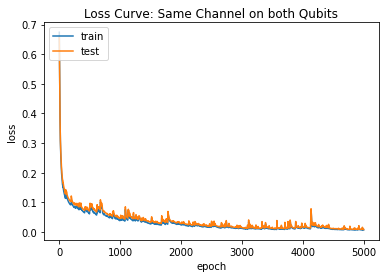

In [232]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Same Channel on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [233]:
score = model.evaluate(x_test,  y_test, verbose=2)

25/25 - 0s - loss: 0.0081 - 322ms/epoch - 13ms/step


In [234]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_same_inf = tf.math.reduce_mean(fid)
print(fid_same_inf)

tf.Tensor((0.991869-2.1884937e-06j), shape=(), dtype=complex64)


### <font color='red'>One Channel on one Qubit</font>

In [235]:
# Generate data
data = generate_Haar_data(2, 2000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [236]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()

    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [237]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [238]:
x_train_list = vectors_with_noise[:800]
y_train_list = vectors_noise_free[:800]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[1800:1900]
y_val_list = vectors_noise_free[1800:1900]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[1900:]
y_test_list = vectors_noise_free[1900:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [242]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

In [243]:
# Compile model
adam_opt = tf.optimizers.Adam(0.00018)
model.compile(optimizer=adam_opt,
              loss=infidelity)

In [244]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=5000)

Epoch 1/5000
8/8 [==============================] - 2s 56ms/step - loss: 0.7329 - val_loss: 0.7195
Epoch 2/5000
8/8 [==============================] - 0s 23ms/step - loss: 0.7088 - val_loss: 0.6961
Epoch 3/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.6870 - val_loss: 0.6762
Epoch 4/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.6680 - val_loss: 0.6568
Epoch 5/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.6485 - val_loss: 0.6371
Epoch 6/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.6298 - val_loss: 0.6193
Epoch 7/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.6118 - val_loss: 0.6007
Epoch 8/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.5931 - val_loss: 0.5816
Epoch 9/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.5751 - val_loss: 0.5650
Epoch 10/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.5596 - val_loss: 0.5490
Epoch 11/

8/8 [==============================] - 0s 15ms/step - loss: 0.2209 - val_loss: 0.2319
Epoch 84/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.2204 - val_loss: 0.2315
Epoch 85/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.2197 - val_loss: 0.2306
Epoch 86/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.2189 - val_loss: 0.2299
Epoch 87/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.2198 - val_loss: 0.2346
Epoch 88/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.2247 - val_loss: 0.2384
Epoch 89/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.2273 - val_loss: 0.2397
Epoch 90/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.2280 - val_loss: 0.2397
Epoch 91/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.2276 - val_loss: 0.2386
Epoch 92/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.2264 - val_loss: 0.2371
Epoch 93/5000


8/8 [==============================] - 0s 21ms/step - loss: 0.1860 - val_loss: 0.1923
Epoch 165/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.1854 - val_loss: 0.1916
Epoch 166/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.1847 - val_loss: 0.1902
Epoch 167/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.1837 - val_loss: 0.1892
Epoch 168/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.1829 - val_loss: 0.1885
Epoch 169/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.1823 - val_loss: 0.1880
Epoch 170/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.1818 - val_loss: 0.1876
Epoch 171/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.1813 - val_loss: 0.1871
Epoch 172/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.1809 - val_loss: 0.1865
Epoch 173/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.1803 - val_loss: 0.1859
Epoch

8/8 [==============================] - 0s 16ms/step - loss: 0.1709 - val_loss: 0.1725
Epoch 246/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.1704 - val_loss: 0.1720
Epoch 247/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.1699 - val_loss: 0.1716
Epoch 248/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.1694 - val_loss: 0.1711
Epoch 249/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.1689 - val_loss: 0.1706
Epoch 250/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.1684 - val_loss: 0.1701
Epoch 251/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.1678 - val_loss: 0.1696
Epoch 252/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.1672 - val_loss: 0.1689
Epoch 253/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.1664 - val_loss: 0.1682
Epoch 254/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.1658 - val_loss: 0.1677
Epoch

8/8 [==============================] - 0s 16ms/step - loss: 0.1468 - val_loss: 0.1531
Epoch 327/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.1474 - val_loss: 0.1533
Epoch 328/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.1475 - val_loss: 0.1531
Epoch 329/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.1473 - val_loss: 0.1528
Epoch 330/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.1469 - val_loss: 0.1523
Epoch 331/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.1465 - val_loss: 0.1520
Epoch 332/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.1460 - val_loss: 0.1515
Epoch 333/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.1456 - val_loss: 0.1510
Epoch 334/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.1451 - val_loss: 0.1506
Epoch 335/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.1447 - val_loss: 0.1502
Epoch

8/8 [==============================] - 0s 16ms/step - loss: 0.1333 - val_loss: 0.1420
Epoch 408/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.1369 - val_loss: 0.1445
Epoch 409/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1382 - val_loss: 0.1451
Epoch 410/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.1383 - val_loss: 0.1448
Epoch 411/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.1378 - val_loss: 0.1441
Epoch 412/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.1370 - val_loss: 0.1431
Epoch 413/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.1361 - val_loss: 0.1422
Epoch 414/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.1359 - val_loss: 0.1427
Epoch 415/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.1365 - val_loss: 0.1427
Epoch 416/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.1364 - val_loss: 0.1422
Epoch

8/8 [==============================] - 0s 21ms/step - loss: 0.1101 - val_loss: 0.1163
Epoch 489/5000
8/8 [==============================] - 0s 23ms/step - loss: 0.1096 - val_loss: 0.1158
Epoch 490/5000
8/8 [==============================] - 0s 22ms/step - loss: 0.1092 - val_loss: 0.1154
Epoch 491/5000
8/8 [==============================] - 0s 22ms/step - loss: 0.1087 - val_loss: 0.1147
Epoch 492/5000
8/8 [==============================] - 0s 22ms/step - loss: 0.1081 - val_loss: 0.1142
Epoch 493/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.1078 - val_loss: 0.1141
Epoch 494/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.1082 - val_loss: 0.1142
Epoch 495/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.1083 - val_loss: 0.1140
Epoch 496/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.1081 - val_loss: 0.1137
Epoch 497/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.1078 - val_loss: 0.1133
Epoch

8/8 [==============================] - 0s 21ms/step - loss: 0.0950 - val_loss: 0.1009
Epoch 570/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0956 - val_loss: 0.1011
Epoch 571/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0957 - val_loss: 0.1010
Epoch 572/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0955 - val_loss: 0.1006
Epoch 573/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0951 - val_loss: 0.1002
Epoch 574/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0946 - val_loss: 0.0998
Epoch 575/5000
8/8 [==============================] - 0s 22ms/step - loss: 0.0942 - val_loss: 0.0994
Epoch 576/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0938 - val_loss: 0.0991
Epoch 577/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0935 - val_loss: 0.0989
Epoch 578/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0934 - val_loss: 0.0988
Epoch

8/8 [==============================] - 0s 20ms/step - loss: 0.0875 - val_loss: 0.0939
Epoch 651/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0873 - val_loss: 0.0937
Epoch 652/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0871 - val_loss: 0.0935
Epoch 653/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0868 - val_loss: 0.0933
Epoch 654/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0867 - val_loss: 0.0932
Epoch 655/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0865 - val_loss: 0.0930
Epoch 656/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0863 - val_loss: 0.0928
Epoch 657/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0861 - val_loss: 0.0926
Epoch 658/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0858 - val_loss: 0.0924
Epoch 659/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0856 - val_loss: 0.0922
Epoch

8/8 [==============================] - 0s 15ms/step - loss: 0.0901 - val_loss: 0.0959
Epoch 732/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0893 - val_loss: 0.0951
Epoch 733/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0882 - val_loss: 0.0936
Epoch 734/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0866 - val_loss: 0.0926
Epoch 735/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0857 - val_loss: 0.0920
Epoch 736/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0850 - val_loss: 0.0915
Epoch 737/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0845 - val_loss: 0.0910
Epoch 738/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0839 - val_loss: 0.0905
Epoch 739/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0834 - val_loss: 0.0900
Epoch 740/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0829 - val_loss: 0.0896
Epoch

8/8 [==============================] - 0s 15ms/step - loss: 0.0727 - val_loss: 0.0794
Epoch 813/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0725 - val_loss: 0.0788
Epoch 814/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0716 - val_loss: 0.0788
Epoch 815/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0717 - val_loss: 0.0792
Epoch 816/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0718 - val_loss: 0.0793
Epoch 817/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0718 - val_loss: 0.0792
Epoch 818/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0716 - val_loss: 0.0790
Epoch 819/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0714 - val_loss: 0.0788
Epoch 820/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0711 - val_loss: 0.0786
Epoch 821/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0709 - val_loss: 0.0783
Epoch

8/8 [==============================] - 0s 16ms/step - loss: 0.0629 - val_loss: 0.0707
Epoch 894/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0626 - val_loss: 0.0704
Epoch 895/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0623 - val_loss: 0.0701
Epoch 896/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0621 - val_loss: 0.0699
Epoch 897/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0618 - val_loss: 0.0696
Epoch 898/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0616 - val_loss: 0.0693
Epoch 899/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0614 - val_loss: 0.0690
Epoch 900/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0611 - val_loss: 0.0688
Epoch 901/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0609 - val_loss: 0.0685
Epoch 902/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0607 - val_loss: 0.0683
Epoch

8/8 [==============================] - 0s 19ms/step - loss: 0.0556 - val_loss: 0.0627
Epoch 975/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0553 - val_loss: 0.0623
Epoch 976/5000
8/8 [==============================] - 0s 22ms/step - loss: 0.0549 - val_loss: 0.0620
Epoch 977/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0547 - val_loss: 0.0619
Epoch 978/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0546 - val_loss: 0.0619
Epoch 979/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0546 - val_loss: 0.0617
Epoch 980/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0544 - val_loss: 0.0615
Epoch 981/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0542 - val_loss: 0.0613
Epoch 982/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0539 - val_loss: 0.0619
Epoch 983/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0557 - val_loss: 0.0654
Epoch

8/8 [==============================] - 0s 19ms/step - loss: 0.0520 - val_loss: 0.0587
Epoch 1055/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0530 - val_loss: 0.0600
Epoch 1056/5000
8/8 [==============================] - 0s 22ms/step - loss: 0.0559 - val_loss: 0.0616
Epoch 1057/5000
8/8 [==============================] - 0s 22ms/step - loss: 0.0575 - val_loss: 0.0620
Epoch 1058/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0577 - val_loss: 0.0617
Epoch 1059/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0571 - val_loss: 0.0604
Epoch 1060/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0554 - val_loss: 0.0597
Epoch 1061/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0547 - val_loss: 0.0594
Epoch 1062/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0542 - val_loss: 0.0590
Epoch 1063/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0537 - val_loss: 0.0

8/8 [==============================] - 0s 19ms/step - loss: 0.0500 - val_loss: 0.0545
Epoch 1135/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0497 - val_loss: 0.0540
Epoch 1136/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0491 - val_loss: 0.0535
Epoch 1137/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0485 - val_loss: 0.0529
Epoch 1138/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0480 - val_loss: 0.0525
Epoch 1139/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0476 - val_loss: 0.0522
Epoch 1140/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0472 - val_loss: 0.0521
Epoch 1141/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0478 - val_loss: 0.0534
Epoch 1142/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0489 - val_loss: 0.0540
Epoch 1143/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0492 - val_loss: 0.0

8/8 [==============================] - 0s 19ms/step - loss: 0.0778 - val_loss: 0.0883
Epoch 1215/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0803 - val_loss: 0.0894
Epoch 1216/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0805 - val_loss: 0.0889
Epoch 1217/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0797 - val_loss: 0.0878
Epoch 1218/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0784 - val_loss: 0.0863
Epoch 1219/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0769 - val_loss: 0.0848
Epoch 1220/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0755 - val_loss: 0.0833
Epoch 1221/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0740 - val_loss: 0.0819
Epoch 1222/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0727 - val_loss: 0.0804
Epoch 1223/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0711 - val_loss: 0.0

8/8 [==============================] - 0s 16ms/step - loss: 0.0474 - val_loss: 0.0564
Epoch 1295/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0472 - val_loss: 0.0562
Epoch 1296/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0470 - val_loss: 0.0559
Epoch 1297/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0468 - val_loss: 0.0557
Epoch 1298/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0465 - val_loss: 0.0555
Epoch 1299/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0463 - val_loss: 0.0553
Epoch 1300/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0461 - val_loss: 0.0551
Epoch 1301/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0460 - val_loss: 0.0549
Epoch 1302/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0458 - val_loss: 0.0546
Epoch 1303/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0456 - val_loss: 0.0

8/8 [==============================] - 0s 17ms/step - loss: 0.0398 - val_loss: 0.0480
Epoch 1375/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0398 - val_loss: 0.0480
Epoch 1376/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0398 - val_loss: 0.0479
Epoch 1377/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0396 - val_loss: 0.0477
Epoch 1378/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0395 - val_loss: 0.0475
Epoch 1379/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0393 - val_loss: 0.0474
Epoch 1380/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0392 - val_loss: 0.0472
Epoch 1381/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0391 - val_loss: 0.0470
Epoch 1382/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0389 - val_loss: 0.0469
Epoch 1383/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.0388 - val_loss: 0.0

8/8 [==============================] - 0s 21ms/step - loss: 0.0542 - val_loss: 0.0578
Epoch 1455/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0534 - val_loss: 0.0566
Epoch 1456/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0518 - val_loss: 0.0550
Epoch 1457/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0510 - val_loss: 0.0547
Epoch 1458/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0512 - val_loss: 0.0545
Epoch 1459/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0510 - val_loss: 0.0541
Epoch 1460/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0507 - val_loss: 0.0536
Epoch 1461/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0502 - val_loss: 0.0532
Epoch 1462/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0497 - val_loss: 0.0528
Epoch 1463/5000
8/8 [==============================] - 0s 22ms/step - loss: 0.0493 - val_loss: 0.0

8/8 [==============================] - 0s 18ms/step - loss: 0.0382 - val_loss: 0.0439
Epoch 1535/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0381 - val_loss: 0.0439
Epoch 1536/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0384 - val_loss: 0.0446
Epoch 1537/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0390 - val_loss: 0.0453
Epoch 1538/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0394 - val_loss: 0.0455
Epoch 1539/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0395 - val_loss: 0.0455
Epoch 1540/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0394 - val_loss: 0.0454
Epoch 1541/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0397 - val_loss: 0.0490
Epoch 1542/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0466 - val_loss: 0.0582
Epoch 1543/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0534 - val_loss: 0.0

8/8 [==============================] - 0s 17ms/step - loss: 0.0405 - val_loss: 0.0464
Epoch 1615/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0404 - val_loss: 0.0463
Epoch 1616/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0402 - val_loss: 0.0461
Epoch 1617/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0403 - val_loss: 0.0466
Epoch 1618/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0407 - val_loss: 0.0468
Epoch 1619/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0407 - val_loss: 0.0468
Epoch 1620/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0407 - val_loss: 0.0467
Epoch 1621/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0410 - val_loss: 0.0474
Epoch 1622/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0421 - val_loss: 0.0481
Epoch 1623/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0427 - val_loss: 0.0

8/8 [==============================] - 0s 18ms/step - loss: 0.0346 - val_loss: 0.0409
Epoch 1695/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0345 - val_loss: 0.0408
Epoch 1696/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0344 - val_loss: 0.0404
Epoch 1697/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0342 - val_loss: 0.0402
Epoch 1698/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0342 - val_loss: 0.0401
Epoch 1699/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0341 - val_loss: 0.0400
Epoch 1700/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0340 - val_loss: 0.0399
Epoch 1701/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0339 - val_loss: 0.0398
Epoch 1702/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0338 - val_loss: 0.0397
Epoch 1703/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0337 - val_loss: 0.0

8/8 [==============================] - 0s 22ms/step - loss: 0.0329 - val_loss: 0.0387
Epoch 1775/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0329 - val_loss: 0.0393
Epoch 1776/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0335 - val_loss: 0.0401
Epoch 1777/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0340 - val_loss: 0.0405
Epoch 1778/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0341 - val_loss: 0.0405
Epoch 1779/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0340 - val_loss: 0.0403
Epoch 1780/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0339 - val_loss: 0.0401
Epoch 1781/5000
8/8 [==============================] - 0s 22ms/step - loss: 0.0337 - val_loss: 0.0399
Epoch 1782/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0335 - val_loss: 0.0397
Epoch 1783/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0333 - val_loss: 0.0

8/8 [==============================] - 0s 15ms/step - loss: 0.0361 - val_loss: 0.0403
Epoch 1855/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0358 - val_loss: 0.0401
Epoch 1856/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0355 - val_loss: 0.0398
Epoch 1857/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0356 - val_loss: 0.0409
Epoch 1858/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0395 - val_loss: 0.0465
Epoch 1859/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0444 - val_loss: 0.0500
Epoch 1860/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0454 - val_loss: 0.0470
Epoch 1861/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0415 - val_loss: 0.0450
Epoch 1862/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0401 - val_loss: 0.0443
Epoch 1863/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0394 - val_loss: 0.0

8/8 [==============================] - 0s 20ms/step - loss: 0.0327 - val_loss: 0.0367
Epoch 1935/5000
8/8 [==============================] - 0s 22ms/step - loss: 0.0333 - val_loss: 0.0369
Epoch 1936/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0334 - val_loss: 0.0368
Epoch 1937/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0333 - val_loss: 0.0366
Epoch 1938/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0334 - val_loss: 0.0376
Epoch 1939/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0350 - val_loss: 0.0388
Epoch 1940/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0359 - val_loss: 0.0392
Epoch 1941/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0361 - val_loss: 0.0392
Epoch 1942/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0358 - val_loss: 0.0388
Epoch 1943/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0353 - val_loss: 0.0

8/8 [==============================] - 0s 20ms/step - loss: 0.0311 - val_loss: 0.0345
Epoch 2015/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0308 - val_loss: 0.0342
Epoch 2016/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0305 - val_loss: 0.0340
Epoch 2017/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0303 - val_loss: 0.0338
Epoch 2018/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0301 - val_loss: 0.0336
Epoch 2019/5000
8/8 [==============================] - 0s 22ms/step - loss: 0.0299 - val_loss: 0.0334
Epoch 2020/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0297 - val_loss: 0.0333
Epoch 2021/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0295 - val_loss: 0.0331
Epoch 2022/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0294 - val_loss: 0.0330
Epoch 2023/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0292 - val_loss: 0.0

8/8 [==============================] - 0s 17ms/step - loss: 0.0275 - val_loss: 0.0310
Epoch 2095/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0274 - val_loss: 0.0309
Epoch 2096/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0273 - val_loss: 0.0307
Epoch 2097/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0272 - val_loss: 0.0307
Epoch 2098/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0271 - val_loss: 0.0306
Epoch 2099/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0270 - val_loss: 0.0305
Epoch 2100/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0269 - val_loss: 0.0305
Epoch 2101/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0270 - val_loss: 0.0311
Epoch 2102/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0278 - val_loss: 0.0317
Epoch 2103/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0283 - val_loss: 0.0

8/8 [==============================] - 0s 21ms/step - loss: 0.0240 - val_loss: 0.0277
Epoch 2175/5000
8/8 [==============================] - 0s 22ms/step - loss: 0.0239 - val_loss: 0.0277
Epoch 2176/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0242 - val_loss: 0.0295
Epoch 2177/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0272 - val_loss: 0.0326
Epoch 2178/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0296 - val_loss: 0.0339
Epoch 2179/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0302 - val_loss: 0.0339
Epoch 2180/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0299 - val_loss: 0.0333
Epoch 2181/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0292 - val_loss: 0.0326
Epoch 2182/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0285 - val_loss: 0.0319
Epoch 2183/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0280 - val_loss: 0.0

8/8 [==============================] - 0s 16ms/step - loss: 0.0237 - val_loss: 0.0275
Epoch 2255/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0234 - val_loss: 0.0273
Epoch 2256/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0232 - val_loss: 0.0271
Epoch 2257/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.0231 - val_loss: 0.0269
Epoch 2258/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.0229 - val_loss: 0.0268
Epoch 2259/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.0228 - val_loss: 0.0266
Epoch 2260/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0226 - val_loss: 0.0265
Epoch 2261/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0225 - val_loss: 0.0264
Epoch 2262/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0224 - val_loss: 0.0263
Epoch 2263/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0224 - val_loss: 0.0

8/8 [==============================] - 0s 18ms/step - loss: 0.0220 - val_loss: 0.0266
Epoch 2335/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0219 - val_loss: 0.0265
Epoch 2336/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0218 - val_loss: 0.0264
Epoch 2337/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0217 - val_loss: 0.0262
Epoch 2338/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0216 - val_loss: 0.0261
Epoch 2339/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0215 - val_loss: 0.0261
Epoch 2340/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0214 - val_loss: 0.0260
Epoch 2341/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0214 - val_loss: 0.0259
Epoch 2342/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0213 - val_loss: 0.0258
Epoch 2343/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0212 - val_loss: 0.0

8/8 [==============================] - 0s 15ms/step - loss: 0.0239 - val_loss: 0.0267
Epoch 2415/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0236 - val_loss: 0.0262
Epoch 2416/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0229 - val_loss: 0.0256
Epoch 2417/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0223 - val_loss: 0.0251
Epoch 2418/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0217 - val_loss: 0.0246
Epoch 2419/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0212 - val_loss: 0.0243
Epoch 2420/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0208 - val_loss: 0.0240
Epoch 2421/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0204 - val_loss: 0.0238
Epoch 2422/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0202 - val_loss: 0.0236
Epoch 2423/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0200 - val_loss: 0.0

8/8 [==============================] - 0s 21ms/step - loss: 0.0207 - val_loss: 0.0250
Epoch 2495/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0204 - val_loss: 0.0247
Epoch 2496/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0201 - val_loss: 0.0244
Epoch 2497/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0198 - val_loss: 0.0241
Epoch 2498/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0196 - val_loss: 0.0238
Epoch 2499/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0193 - val_loss: 0.0236
Epoch 2500/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0192 - val_loss: 0.0234
Epoch 2501/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0190 - val_loss: 0.0233
Epoch 2502/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0189 - val_loss: 0.0232
Epoch 2503/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0188 - val_loss: 0.0

8/8 [==============================] - 0s 19ms/step - loss: 0.0163 - val_loss: 0.0199
Epoch 2575/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0166 - val_loss: 0.0213
Epoch 2576/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0175 - val_loss: 0.0222
Epoch 2577/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0179 - val_loss: 0.0224
Epoch 2578/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0178 - val_loss: 0.0222
Epoch 2579/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0176 - val_loss: 0.0219
Epoch 2580/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0173 - val_loss: 0.0215
Epoch 2581/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0171 - val_loss: 0.0213
Epoch 2582/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0169 - val_loss: 0.0210
Epoch 2583/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0167 - val_loss: 0.0

8/8 [==============================] - 0s 15ms/step - loss: 0.0155 - val_loss: 0.0189
Epoch 2655/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0154 - val_loss: 0.0188
Epoch 2656/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0154 - val_loss: 0.0188
Epoch 2657/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0154 - val_loss: 0.0187
Epoch 2658/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0154 - val_loss: 0.0188
Epoch 2659/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0153 - val_loss: 0.0187
Epoch 2660/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0153 - val_loss: 0.0187
Epoch 2661/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0153 - val_loss: 0.0187
Epoch 2662/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0152 - val_loss: 0.0186
Epoch 2663/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0152 - val_loss: 0.0

8/8 [==============================] - 0s 21ms/step - loss: 0.0145 - val_loss: 0.0174
Epoch 2735/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0144 - val_loss: 0.0173
Epoch 2736/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0144 - val_loss: 0.0173
Epoch 2737/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0143 - val_loss: 0.0172
Epoch 2738/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0143 - val_loss: 0.0172
Epoch 2739/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0143 - val_loss: 0.0172
Epoch 2740/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0142 - val_loss: 0.0171
Epoch 2741/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0142 - val_loss: 0.0171
Epoch 2742/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0142 - val_loss: 0.0171
Epoch 2743/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0141 - val_loss: 0.0

8/8 [==============================] - 0s 21ms/step - loss: 0.0162 - val_loss: 0.0199
Epoch 2815/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0161 - val_loss: 0.0198
Epoch 2816/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0160 - val_loss: 0.0197
Epoch 2817/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0160 - val_loss: 0.0196
Epoch 2818/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0159 - val_loss: 0.0196
Epoch 2819/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0158 - val_loss: 0.0195
Epoch 2820/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0158 - val_loss: 0.0195
Epoch 2821/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0157 - val_loss: 0.0194
Epoch 2822/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0156 - val_loss: 0.0193
Epoch 2823/5000
8/8 [==============================] - 0s 22ms/step - loss: 0.0156 - val_loss: 0.0

8/8 [==============================] - 0s 20ms/step - loss: 0.0225 - val_loss: 0.0240
Epoch 2895/5000
8/8 [==============================] - 0s 22ms/step - loss: 0.0212 - val_loss: 0.0229
Epoch 2896/5000
8/8 [==============================] - 0s 22ms/step - loss: 0.0200 - val_loss: 0.0218
Epoch 2897/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0193 - val_loss: 0.0221
Epoch 2898/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0202 - val_loss: 0.0226
Epoch 2899/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0204 - val_loss: 0.0223
Epoch 2900/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0199 - val_loss: 0.0216
Epoch 2901/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0191 - val_loss: 0.0208
Epoch 2902/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0183 - val_loss: 0.0202
Epoch 2903/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0176 - val_loss: 0.0

8/8 [==============================] - 0s 15ms/step - loss: 0.0259 - val_loss: 0.0275
Epoch 2975/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0247 - val_loss: 0.0261
Epoch 2976/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0233 - val_loss: 0.0248
Epoch 2977/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0221 - val_loss: 0.0236
Epoch 2978/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.0210 - val_loss: 0.0226
Epoch 2979/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0201 - val_loss: 0.0218
Epoch 2980/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0194 - val_loss: 0.0211
Epoch 2981/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0187 - val_loss: 0.0205
Epoch 2982/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0181 - val_loss: 0.0199
Epoch 2983/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.0176 - val_loss: 0.0

8/8 [==============================] - 0s 17ms/step - loss: 0.0161 - val_loss: 0.0188
Epoch 3055/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0155 - val_loss: 0.0182
Epoch 3056/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0150 - val_loss: 0.0178
Epoch 3057/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0147 - val_loss: 0.0174
Epoch 3058/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0143 - val_loss: 0.0171
Epoch 3059/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0145 - val_loss: 0.0181
Epoch 3060/5000
8/8 [==============================] - 0s 24ms/step - loss: 0.0158 - val_loss: 0.0191
Epoch 3061/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0167 - val_loss: 0.0194
Epoch 3062/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0167 - val_loss: 0.0191
Epoch 3063/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0164 - val_loss: 0.0

8/8 [==============================] - 0s 20ms/step - loss: 0.0138 - val_loss: 0.0171
Epoch 3135/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0135 - val_loss: 0.0168
Epoch 3136/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0132 - val_loss: 0.0166
Epoch 3137/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0130 - val_loss: 0.0164
Epoch 3138/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0128 - val_loss: 0.0162
Epoch 3139/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0127 - val_loss: 0.0160
Epoch 3140/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0127 - val_loss: 0.0160
Epoch 3141/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0127 - val_loss: 0.0159
Epoch 3142/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0126 - val_loss: 0.0158
Epoch 3143/5000
8/8 [==============================] - 0s 24ms/step - loss: 0.0126 - val_loss: 0.0

8/8 [==============================] - 0s 19ms/step - loss: 0.0109 - val_loss: 0.0135
Epoch 3215/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0109 - val_loss: 0.0135
Epoch 3216/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0109 - val_loss: 0.0134
Epoch 3217/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0109 - val_loss: 0.0134
Epoch 3218/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0109 - val_loss: 0.0134
Epoch 3219/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0109 - val_loss: 0.0134
Epoch 3220/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0109 - val_loss: 0.0134
Epoch 3221/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0109 - val_loss: 0.0134
Epoch 3222/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0109 - val_loss: 0.0133
Epoch 3223/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0108 - val_loss: 0.0

8/8 [==============================] - 0s 16ms/step - loss: 0.0100 - val_loss: 0.0125
Epoch 3295/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0100 - val_loss: 0.0125
Epoch 3296/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.0100 - val_loss: 0.0125
Epoch 3297/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0100 - val_loss: 0.0125
Epoch 3298/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0100 - val_loss: 0.0125
Epoch 3299/5000
8/8 [==============================] - 0s 22ms/step - loss: 0.0099 - val_loss: 0.0125
Epoch 3300/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0099 - val_loss: 0.0125
Epoch 3301/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0099 - val_loss: 0.0124
Epoch 3302/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0099 - val_loss: 0.0124
Epoch 3303/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0099 - val_loss: 0.0

8/8 [==============================] - 0s 18ms/step - loss: 0.0094 - val_loss: 0.0120
Epoch 3375/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0093 - val_loss: 0.0120
Epoch 3376/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0093 - val_loss: 0.0119
Epoch 3377/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0093 - val_loss: 0.0119
Epoch 3378/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0093 - val_loss: 0.0119
Epoch 3379/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0093 - val_loss: 0.0119
Epoch 3380/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0093 - val_loss: 0.0119
Epoch 3381/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0093 - val_loss: 0.0119
Epoch 3382/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0092 - val_loss: 0.0118
Epoch 3383/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0092 - val_loss: 0.0

8/8 [==============================] - 0s 16ms/step - loss: 0.0140 - val_loss: 0.0156
Epoch 3455/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0136 - val_loss: 0.0153
Epoch 3456/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0133 - val_loss: 0.0151
Epoch 3457/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0130 - val_loss: 0.0149
Epoch 3458/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0128 - val_loss: 0.0148
Epoch 3459/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0127 - val_loss: 0.0147
Epoch 3460/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0126 - val_loss: 0.0146
Epoch 3461/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0124 - val_loss: 0.0145
Epoch 3462/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0123 - val_loss: 0.0144
Epoch 3463/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0122 - val_loss: 0.0

8/8 [==============================] - 0s 19ms/step - loss: 0.0095 - val_loss: 0.0120
Epoch 3535/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.0095 - val_loss: 0.0119
Epoch 3536/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0095 - val_loss: 0.0119
Epoch 3537/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0094 - val_loss: 0.0118
Epoch 3538/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0094 - val_loss: 0.0118
Epoch 3539/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0094 - val_loss: 0.0118
Epoch 3540/5000
8/8 [==============================] - 0s 22ms/step - loss: 0.0094 - val_loss: 0.0118
Epoch 3541/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0093 - val_loss: 0.0117
Epoch 3542/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0093 - val_loss: 0.0117
Epoch 3543/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0093 - val_loss: 0.0

8/8 [==============================] - 0s 16ms/step - loss: 0.0083 - val_loss: 0.0105
Epoch 3615/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0082 - val_loss: 0.0105
Epoch 3616/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0082 - val_loss: 0.0104
Epoch 3617/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0082 - val_loss: 0.0105
Epoch 3618/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0082 - val_loss: 0.0104
Epoch 3619/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0082 - val_loss: 0.0104
Epoch 3620/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0082 - val_loss: 0.0104
Epoch 3621/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0081 - val_loss: 0.0104
Epoch 3622/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0081 - val_loss: 0.0104
Epoch 3623/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0084 - val_loss: 0.0

8/8 [==============================] - 0s 16ms/step - loss: 0.0094 - val_loss: 0.0120
Epoch 3695/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0094 - val_loss: 0.0120
Epoch 3696/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0095 - val_loss: 0.0123
Epoch 3697/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0103 - val_loss: 0.0132
Epoch 3698/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0109 - val_loss: 0.0135
Epoch 3699/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.0108 - val_loss: 0.0133
Epoch 3700/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0106 - val_loss: 0.0130
Epoch 3701/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0102 - val_loss: 0.0127
Epoch 3702/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0100 - val_loss: 0.0125
Epoch 3703/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0099 - val_loss: 0.0

8/8 [==============================] - 0s 16ms/step - loss: 0.0080 - val_loss: 0.0103
Epoch 3775/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0080 - val_loss: 0.0103
Epoch 3776/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0080 - val_loss: 0.0103
Epoch 3777/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0080 - val_loss: 0.0103
Epoch 3778/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0079 - val_loss: 0.0102
Epoch 3779/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0079 - val_loss: 0.0103
Epoch 3780/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0079 - val_loss: 0.0102
Epoch 3781/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0079 - val_loss: 0.0102
Epoch 3782/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0079 - val_loss: 0.0102
Epoch 3783/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0079 - val_loss: 0.0

8/8 [==============================] - 0s 16ms/step - loss: 0.0320 - val_loss: 0.0296
Epoch 3855/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0284 - val_loss: 0.0272
Epoch 3856/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0263 - val_loss: 0.0258
Epoch 3857/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0250 - val_loss: 0.0247
Epoch 3858/5000
8/8 [==============================] - 0s 23ms/step - loss: 0.0238 - val_loss: 0.0237
Epoch 3859/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0227 - val_loss: 0.0227
Epoch 3860/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0218 - val_loss: 0.0219
Epoch 3861/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0210 - val_loss: 0.0212
Epoch 3862/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0202 - val_loss: 0.0206
Epoch 3863/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0196 - val_loss: 0.0

8/8 [==============================] - 0s 16ms/step - loss: 0.0172 - val_loss: 0.0185
Epoch 3935/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0169 - val_loss: 0.0183
Epoch 3936/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0168 - val_loss: 0.0183
Epoch 3937/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0167 - val_loss: 0.0182
Epoch 3938/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0166 - val_loss: 0.0181
Epoch 3939/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0165 - val_loss: 0.0180
Epoch 3940/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0164 - val_loss: 0.0178
Epoch 3941/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0162 - val_loss: 0.0180
Epoch 3942/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0169 - val_loss: 0.0192
Epoch 3943/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0178 - val_loss: 0.0

8/8 [==============================] - 0s 14ms/step - loss: 0.0118 - val_loss: 0.0142
Epoch 4015/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0117 - val_loss: 0.0141
Epoch 4016/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0116 - val_loss: 0.0140
Epoch 4017/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0115 - val_loss: 0.0138
Epoch 4018/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0114 - val_loss: 0.0137
Epoch 4019/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0113 - val_loss: 0.0137
Epoch 4020/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0112 - val_loss: 0.0136
Epoch 4021/5000
8/8 [==============================] - 0s 23ms/step - loss: 0.0111 - val_loss: 0.0135
Epoch 4022/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0111 - val_loss: 0.0135
Epoch 4023/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0110 - val_loss: 0.0

8/8 [==============================] - 0s 17ms/step - loss: 0.0094 - val_loss: 0.0116
Epoch 4095/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0094 - val_loss: 0.0116
Epoch 4096/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0093 - val_loss: 0.0116
Epoch 4097/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0093 - val_loss: 0.0116
Epoch 4098/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0093 - val_loss: 0.0115
Epoch 4099/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0092 - val_loss: 0.0115
Epoch 4100/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0092 - val_loss: 0.0114
Epoch 4101/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0092 - val_loss: 0.0114
Epoch 4102/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0092 - val_loss: 0.0114
Epoch 4103/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0091 - val_loss: 0.0

8/8 [==============================] - 0s 20ms/step - loss: 0.0100 - val_loss: 0.0122
Epoch 4175/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0097 - val_loss: 0.0120
Epoch 4176/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0097 - val_loss: 0.0125
Epoch 4177/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0100 - val_loss: 0.0127
Epoch 4178/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0101 - val_loss: 0.0125
Epoch 4179/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0099 - val_loss: 0.0121
Epoch 4180/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0096 - val_loss: 0.0118
Epoch 4181/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0093 - val_loss: 0.0116
Epoch 4182/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0091 - val_loss: 0.0114
Epoch 4183/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0090 - val_loss: 0.0

8/8 [==============================] - 0s 15ms/step - loss: 0.0080 - val_loss: 0.0105
Epoch 4255/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0080 - val_loss: 0.0104
Epoch 4256/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0079 - val_loss: 0.0103
Epoch 4257/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0078 - val_loss: 0.0102
Epoch 4258/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0078 - val_loss: 0.0101
Epoch 4259/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0077 - val_loss: 0.0100
Epoch 4260/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0076 - val_loss: 0.0100
Epoch 4261/5000
8/8 [==============================] - 0s 22ms/step - loss: 0.0076 - val_loss: 0.0099
Epoch 4262/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0075 - val_loss: 0.0098
Epoch 4263/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0075 - val_loss: 0.0

8/8 [==============================] - 0s 16ms/step - loss: 0.0107 - val_loss: 0.0128
Epoch 4335/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0106 - val_loss: 0.0126
Epoch 4336/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0104 - val_loss: 0.0125
Epoch 4337/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0102 - val_loss: 0.0123
Epoch 4338/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0100 - val_loss: 0.0122
Epoch 4339/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0100 - val_loss: 0.0121
Epoch 4340/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0098 - val_loss: 0.0120
Epoch 4341/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0097 - val_loss: 0.0119
Epoch 4342/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0096 - val_loss: 0.0117
Epoch 4343/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0095 - val_loss: 0.0

8/8 [==============================] - 0s 15ms/step - loss: 0.0084 - val_loss: 0.0103
Epoch 4415/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0083 - val_loss: 0.0102
Epoch 4416/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0082 - val_loss: 0.0101
Epoch 4417/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0081 - val_loss: 0.0100
Epoch 4418/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0080 - val_loss: 0.0100
Epoch 4419/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0079 - val_loss: 0.0099
Epoch 4420/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0079 - val_loss: 0.0099
Epoch 4421/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0078 - val_loss: 0.0098
Epoch 4422/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0078 - val_loss: 0.0098
Epoch 4423/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0078 - val_loss: 0.0

8/8 [==============================] - 0s 17ms/step - loss: 0.0069 - val_loss: 0.0087
Epoch 4495/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0068 - val_loss: 0.0087
Epoch 4496/5000
8/8 [==============================] - 0s 27ms/step - loss: 0.0067 - val_loss: 0.0086
Epoch 4497/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0067 - val_loss: 0.0086
Epoch 4498/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0066 - val_loss: 0.0085
Epoch 4499/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0066 - val_loss: 0.0085
Epoch 4500/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0066 - val_loss: 0.0085
Epoch 4501/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0065 - val_loss: 0.0085
Epoch 4502/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0065 - val_loss: 0.0085
Epoch 4503/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0065 - val_loss: 0.0

8/8 [==============================] - 0s 18ms/step - loss: 0.0060 - val_loss: 0.0079
Epoch 4575/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0060 - val_loss: 0.0079
Epoch 4576/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0059 - val_loss: 0.0079
Epoch 4577/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0059 - val_loss: 0.0079
Epoch 4578/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0059 - val_loss: 0.0079
Epoch 4579/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0059 - val_loss: 0.0079
Epoch 4580/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0059 - val_loss: 0.0079
Epoch 4581/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0059 - val_loss: 0.0078
Epoch 4582/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0059 - val_loss: 0.0078
Epoch 4583/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0059 - val_loss: 0.0

8/8 [==============================] - 0s 19ms/step - loss: 0.0057 - val_loss: 0.0079
Epoch 4655/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0057 - val_loss: 0.0079
Epoch 4656/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0057 - val_loss: 0.0079
Epoch 4657/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0057 - val_loss: 0.0079
Epoch 4658/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0057 - val_loss: 0.0079
Epoch 4659/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0057 - val_loss: 0.0079
Epoch 4660/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0057 - val_loss: 0.0079
Epoch 4661/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0057 - val_loss: 0.0078
Epoch 4662/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0057 - val_loss: 0.0078
Epoch 4663/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0056 - val_loss: 0.0

8/8 [==============================] - 0s 18ms/step - loss: 0.0076 - val_loss: 0.0089
Epoch 4735/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0074 - val_loss: 0.0087
Epoch 4736/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0073 - val_loss: 0.0086
Epoch 4737/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0072 - val_loss: 0.0085
Epoch 4738/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0071 - val_loss: 0.0084
Epoch 4739/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0070 - val_loss: 0.0084
Epoch 4740/5000
8/8 [==============================] - 0s 22ms/step - loss: 0.0070 - val_loss: 0.0084
Epoch 4741/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0069 - val_loss: 0.0083
Epoch 4742/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0069 - val_loss: 0.0083
Epoch 4743/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0068 - val_loss: 0.0

8/8 [==============================] - 0s 17ms/step - loss: 0.0054 - val_loss: 0.0070
Epoch 4815/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0054 - val_loss: 0.0070
Epoch 4816/5000
8/8 [==============================] - 0s 22ms/step - loss: 0.0054 - val_loss: 0.0070
Epoch 4817/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0054 - val_loss: 0.0070
Epoch 4818/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0054 - val_loss: 0.0070
Epoch 4819/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0054 - val_loss: 0.0071
Epoch 4820/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0055 - val_loss: 0.0071
Epoch 4821/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0054 - val_loss: 0.0070
Epoch 4822/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0054 - val_loss: 0.0070
Epoch 4823/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0054 - val_loss: 0.0

8/8 [==============================] - 0s 17ms/step - loss: 0.0058 - val_loss: 0.0076
Epoch 4895/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.0058 - val_loss: 0.0074
Epoch 4896/5000
8/8 [==============================] - 0s 22ms/step - loss: 0.0056 - val_loss: 0.0071
Epoch 4897/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.0054 - val_loss: 0.0069
Epoch 4898/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0053 - val_loss: 0.0068
Epoch 4899/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0052 - val_loss: 0.0068
Epoch 4900/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.0052 - val_loss: 0.0067
Epoch 4901/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0051 - val_loss: 0.0067
Epoch 4902/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0051 - val_loss: 0.0066
Epoch 4903/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0051 - val_loss: 0.0

8/8 [==============================] - 0s 16ms/step - loss: 0.0060 - val_loss: 0.0077
Epoch 4975/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0060 - val_loss: 0.0077
Epoch 4976/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0060 - val_loss: 0.0076
Epoch 4977/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0059 - val_loss: 0.0076
Epoch 4978/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.0059 - val_loss: 0.0075
Epoch 4979/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0058 - val_loss: 0.0074
Epoch 4980/5000
8/8 [==============================] - 0s 22ms/step - loss: 0.0058 - val_loss: 0.0074
Epoch 4981/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.0058 - val_loss: 0.0074
Epoch 4982/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0059 - val_loss: 0.0076
Epoch 4983/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0065 - val_loss: 0.0

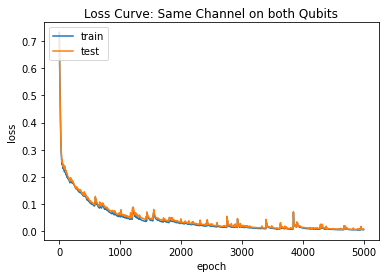

In [245]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Same Channel on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [246]:
score = model.evaluate(x_test,  y_test, verbose=2)

4/4 - 0s - loss: 0.0085 - 365ms/epoch - 91ms/step


In [247]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_one_inf = tf.math.reduce_mean(fid)
print(fid_one_inf)

tf.Tensor((0.99149203-4.11627e-05j), shape=(), dtype=complex64)
